# Creative Gaming: Uplift Modeling

![](images/github-group-workflow.png)

In [5]:
import pyrsm as rsm
# show the content of another notebook
rsm.md_notebook("./sub-notebooks/question1.ipynb")


```python
clf_oc = rsm.model.logistic(
    data={"cg_organic_control": cg_organic_control},
    rvar="converted",
    lev="yes",
    evar=["GameLevel", "NumGameDays", "NumGameDays4Plus"],
)
clf_oc.summary()
```


In [6]:
# load a custom python module
from utils.functions import example

example()


You just accessed a function from your first python packages!
Change the code in utils/function.py to whatever you need for this assignment
Use 'from utils import functions' to get access to your code
You can add modules to import from by adding additional .py files to the 'utils' directory
Note: If you make changes to the content of this file you will have to restart the notebook kernel to get the updates



In [7]:
## Question answers

In [8]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
import xgboost as xgb
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import PartialDependenceDisplay as pdp


In [9]:
## loading the organic data - this dataset must NOT be changed
cg_organic_control = pd.read_parquet("data/cg_organic_control.parquet").reset_index(drop=True)
cg_organic_control.head()

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,TimesLostSpaceship,TimesKilled,TimesCaptain,TimesNavigator,PurchasedCoinPackSmall,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS
0,no,7,18,0,124,0,81,0,yes,no,8,0,0,4,no,yes,3,2101,no,no
1,no,10,3,2,60,0,18,479,no,no,10,7,0,0,yes,no,7,1644,yes,no
2,no,2,1,0,0,0,0,0,no,no,0,0,0,2,no,no,8,3197,yes,yes
3,no,2,11,1,125,0,73,217,no,no,0,0,0,0,yes,no,6,913,no,no
4,no,8,15,0,0,0,6,51,yes,no,0,0,2,1,yes,no,21,2009,yes,no


In [10]:
rsm.md("data/cg_organic_control_description.md")

## Creative gaming

Game telemetry dataset used for the Creative Gaming: Propensity-to-Buy Modeling case

#### Feature descriptions

* converted: Purchased the Zalon campain ("yes" or "no")
* GameLevel: Highest level of game achieved by the user
* NumGameDays: Number of days user played the game in last month (with or without network connection)
* NumGameDays4Plus: Number of days user played the game in last month with 4 or more total users (this implies using a network connection)
* NumInGameMessagesSent: Number of in-game messages sent to friends
* NumFriends: Number of friends to which the user is connected (necessary to crew together in multiplayer mode) 
* NumFriendRequestIgnored: Number of friend requests this user has not replied to since game inception
* NumSpaceHeroBadges: Number of "Space Hero" badges, the highest distinction for gameplay in Space Pirates
* AcquiredSpaceship: Flag if the user owns a spaceship, i.e., does not have to crew on another user's or NPC's space ship ("no" or "yes")
* AcquiredIonWeapon: Flag if the user owns the powerful "ion weapon" ("no" or "yes")
* TimesLostSpaceship: The number of times the user destroyed his/her spaceship during gameplay. Spaceships need to be re-acquired if destroyed.
* TimesKilled: Number of times the user was killed during gameplay
* TimesCaptain: Number of times in last month that the user played in the role of a captain
* TimesNavigator: Number of times in last month that the user played in the role of a navigator
* PurchasedCoinPackSmall: Flag if the user purchased a small pack of Zathium in last month ("no" or "yes")
* PurchasedCoinPackLarge: Flag if the user purchased a large pack of Zathium in last month ("no" or "yes")
* NumAdsClicked: Number of in-app ads the user has clicked on
* DaysUser: Number of days since user established a user ID with Creative Gaming (for Space Pirates or previous games)
* UserConsole: Flag if the user plays Creative Gaming games on a console ("no" or "yes")
* UserHasOldOS: Flag if the user has iOS version 10 or earlier ("no" or "yes")


In [11]:
## loading the treatment data - this dataset must NOT be changed
cg_ad_treatment = pd.read_parquet("data/cg_ad_treatment.parquet").reset_index(drop=True)
cg_ad_treatment.head()

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,TimesKilled,TimesCaptain,TimesNavigator,PurchasedCoinPackSmall,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS,rnd_30k
0,no,6,16,0,0,0,0,0,yes,no,...,0,0,0,no,no,11,1827,no,no,0
1,no,2,8,0,0,0,5,4,no,no,...,0,8,0,yes,no,3,1889,no,yes,1
2,no,6,1,0,0,0,0,0,no,no,...,0,0,0,no,yes,2,1948,yes,no,0
3,yes,7,16,0,102,1,0,194,no,no,...,0,0,0,yes,yes,21,3409,yes,yes,0
4,no,10,1,1,233,0,23,0,no,no,...,0,5,0,no,yes,4,2922,yes,no,0


In [12]:
rsm.md("data/cg_ad_treatment_description.md")

## Creative gaming

Game telemetry dataset used for the Creative Gaming: Propensity-to-Buy Modeling case

#### Feature descriptions

* converted: Purchased the Zalon campain ("yes" or "no")
* GameLevel: Highest level of game achieved by the user
* NumGameDays: Number of days user played the game in last month (with or without network connection)
* NumGameDays4Plus: Number of days user played the game in last month with 4 or more total users (this implies using a network connection)
* NumInGameMessagesSent: Number of in-game messages sent to friends
* NumFriends: Number of friends to which the user is connected (necessary to crew together in multiplayer mode) 
* NumFriendRequestIgnored: Number of friend requests this user has not replied to since game inception
* NumSpaceHeroBadges: Number of "Space Hero" badges, the highest distinction for gameplay in Space Pirates
* AcquiredSpaceship: Flag if the user owns a spaceship, i.e., does not have to crew on another user's or NPC's space ship ("no" or "yes")
* AcquiredIonWeapon: Flag if the user owns the powerful "ion weapon" ("no" or "yes")
* TimesLostSpaceship: The number of times the user destroyed his/her spaceship during gameplay. Spaceships need to be re-acquired if destroyed.
* TimesKilled: Number of times the user was killed during gameplay
* TimesCaptain: Number of times in last month that the user played in the role of a captain
* TimesNavigator: Number of times in last month that the user played in the role of a navigator
* PurchasedCoinPackSmall: Flag if the user purchased a small pack of Zathium in last month ("no" or "yes")
* PurchasedCoinPackLarge: Flag if the user purchased a large pack of Zathium in last month ("no" or "yes")
* NumAdsClicked: Number of in-app ads the user has clicked on
* DaysUser: Number of days since user established a user ID with Creative Gaming (for Space Pirates or previous games)
* UserConsole: Flag if the user plays Creative Gaming games on a console ("no" or "yes")
* UserHasOldOS: Flag if the user has iOS version 10 or earlier ("no" or "yes")
* rnd_30k: Dummy variable that randomly selects 30K customers (1) and the remaining 90K (0)


In [13]:
print(f"PYRSM Version: {rsm.__version__}")


PYRSM Version: 1.2.0


In [14]:
# Load control group data (Customers who did NOT receive an ad)
cg_organic_control = pd.read_parquet("data/cg_organic_control.parquet").reset_index(drop=True)
cg_organic_control.head()


,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,TimesLostSpaceship,TimesKilled,TimesCaptain,TimesNavigator,PurchasedCoinPackSmall,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS
0,no,7,18,0,124,0,81,0,yes,no,8,0,0,4,no,yes,3,2101,no,no
1,no,10,3,2,60,0,18,479,no,no,10,7,0,0,yes,no,7,1644,yes,no
2,no,2,1,0,0,0,0,0,no,no,0,0,0,2,no,no,8,3197,yes,yes
3,no,2,11,1,125,0,73,217,no,no,0,0,0,0,yes,no,6,913,no,no
4,no,8,15,0,0,0,6,51,yes,no,0,0,2,1,yes,no,21,2009,yes,no


In [15]:
# Load treatment group data (Customers who DID receive an ad)
cg_ad_treatment = pd.read_parquet("data/cg_ad_treatment.parquet").reset_index(drop=True)
cg_ad_treatment.head()


,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,TimesKilled,TimesCaptain,TimesNavigator,PurchasedCoinPackSmall,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS,rnd_30k
0,no,6,16,0,0,0,0,0,yes,no,...,0,0,0,no,no,11,1827,no,no,0
1,no,2,8,0,0,0,5,4,no,no,...,0,8,0,yes,no,3,1889,no,yes,1
2,no,6,1,0,0,0,0,0,no,no,...,0,0,0,no,yes,2,1948,yes,no,0
3,yes,7,16,0,102,1,0,194,no,no,...,0,0,0,yes,yes,21,3409,yes,yes,0
4,no,10,1,1,233,0,23,0,no,no,...,0,5,0,no,yes,4,2922,yes,no,0


In [16]:
cg_ad_random = pd.read_parquet("data/cg_ad_random.parquet").reset_index(drop=True)
cg_ad_random["ad"] = 1  # 1 = Ad shown
cg_organic_control["ad"] = 0  # 0 = No ad shown

In [17]:
# Stack control and treatment groups into one dataset
cg_rct_stacked = pd.concat([cg_organic_control, cg_ad_random], ignore_index=True)
print(f"Stacked Dataset Shape: {cg_rct_stacked.shape}")
cg_rct_stacked.head()


Stacked Dataset Shape: (60000, 21)


,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,TimesKilled,TimesCaptain,TimesNavigator,PurchasedCoinPackSmall,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS,ad
0,no,7,18,0,124,0,81,0,yes,no,...,0,0,4,no,yes,3,2101,no,no,0
1,no,10,3,2,60,0,18,479,no,no,...,7,0,0,yes,no,7,1644,yes,no,0
2,no,2,1,0,0,0,0,0,no,no,...,0,0,2,no,no,8,3197,yes,yes,0
3,no,2,11,1,125,0,73,217,no,no,...,0,0,0,yes,no,6,913,no,no,0
4,no,8,15,0,0,0,6,51,yes,no,...,0,2,1,yes,no,21,2009,yes,no,0


The two datasets are merged into a single dataframe, cg_rct_stacked, and a new column ad is added to indicate whether an ad was shown (1) or not (0).A single dataset allows for a direct comparison between users exposed to ads and those who were not.Helps in performing uplift modeling, which predicts the incremental impact of an ad on conversion probability.

In [18]:
#ensure a 70/30 train-test split while stratifying by 'converted' and 'ad'
cg_rct_stacked['training'] = rsm.model.make_train(
    data=cg_rct_stacked, 
    test_size=0.3,  # 30% for testing
    strat_var=['converted', 'ad']
)

cg_rct_stacked.training.value_counts(normalize=True)


training
1.0    0.7
0.0    0.3
Name: proportion, dtype: float64

In [19]:
#pivot table to check conversion rates by ad exposure and training split
pd.crosstab(
    cg_rct_stacked.converted, 
    [cg_rct_stacked.ad, cg_rct_stacked.training], 
    normalize="columns"
).round(2)


ad            0           1      
training    0.0   1.0   0.0   1.0
converted                        
yes        0.06  0.06  0.13  0.13
no         0.94  0.94  0.87  0.87

When ad = 0 (control group), the conversion rate remains consistent across the training and test sets, with 6% of users converting ("yes") and 94% not converting ("no") in both splits.

Similarly, when ad = 1 (treatment group), the conversion rate is 13% for both the training and test sets, while 87% of users did not convert ("no") in both cases.

This balanced distribution confirms that the stratification process was successful, ensuring that the ratio of conversions and non-conversions remains consistent across training and test sets within each group. By maintaining these proportions, the dataset remains representative, allowing for an unbiased evaluation of the impact of ad exposure on user conversion rates.

In [20]:
#pivot table to check ad exposure count across training and test sets
pd.crosstab(cg_rct_stacked.ad, cg_rct_stacked.training)


training,0.0,1.0
ad,,
0,9000,21000
1,9000,21000


The dataset is evenly split between the control group (ad = 0) and the treatment group (ad = 1), ensuring a balanced distribution of users who were and were not exposed to the ad.

In the training set (training = 1.0), there are 21,000 users in the control group and 21,000 users in the treatment group. Similarly, in the test set (training = 0.0), there are 9,000 users in both the control and treatment groups.

This equal allocation of users across groups ensures a fair comparison between the treatment and control conditions. It helps maintain the integrity of the uplift modeling process by preventing any biases that may arise from uneven group distributions, allowing for a more reliable assessment of the ad's impact on conversion rates.

#### Logisitc Model Training

In [21]:
# Train Logistic Regression model for the treatment group (Ad shown)
lr_treatment = rsm.model.logistic(
    data={"cg_rct_stacked": cg_rct_stacked.query("training == 1 & ad == 1")},  # Filter training set where ad was shown
    rvar="converted",
    lev="yes",
    evar=cg_rct_stacked.loc[:, "GameLevel":"UserHasOldOS"].columns.tolist(),
)

lr_treatment.summary()


Logistic regression (GLM)
Data                 : cg_rct_stacked
Response variable    : converted
Level                : yes
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumSpaceHeroBadges, NumFriendRequestIgnored, NumFriends, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
Null hyp.: There is no effect of x on converted
Alt. hyp.: There is an effect of x on converted

                                OR     OR%  coefficient  std.error  z.value p.value     
Intercept                    0.030  -97.0%        -3.52      0.122  -28.987  < .001  ***
AcquiredSpaceship[yes]       1.088    8.8%         0.08      0.049    1.732   0.083    .
AcquiredIonWeapon[yes]       0.917   -8.3%        -0.09      0.164   -0.533   0.594     
PurchasedCoinPackSmall[yes]  1.045    4.5%         0.04      0.046    0.960   

In [22]:
# Train Logistic Regression model for the control group (No Ad)
lr_control = rsm.model.logistic(
    data={"cg_rct_stacked": cg_rct_stacked.query("training == 1 & ad == 0")},  # Filter training set where no ad was shown
    rvar="converted",  
    lev="yes",  
    evar=cg_rct_stacked.loc[:, "GameLevel":"UserHasOldOS"].columns.tolist(),
)

lr_control.summary()


Logistic regression (GLM)
Data                 : cg_rct_stacked
Response variable    : converted
Level                : yes
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumSpaceHeroBadges, NumFriendRequestIgnored, NumFriends, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
Null hyp.: There is no effect of x on converted
Alt. hyp.: There is an effect of x on converted

                                OR     OR%  coefficient  std.error  z.value p.value     
Intercept                    0.006  -99.4%        -5.18      0.193  -26.809  < .001  ***
AcquiredSpaceship[yes]       1.594   59.4%         0.47      0.072    6.472  < .001  ***
AcquiredIonWeapon[yes]       0.860  -14.0%        -0.15      0.267   -0.566   0.571     
PurchasedCoinPackSmall[yes]  1.029    2.9%         0.03      0.069    0.415   

In [23]:
# Predict conversion probability for the treatment group
cg_rct_stacked["pred_treatment"] = lr_treatment.predict(cg_rct_stacked)["prediction"]

# Predict conversion probability for the control group
cg_rct_stacked["pred_control"] = lr_control.predict(cg_rct_stacked)["prediction"]

# Compute uplift score (Difference between treatment and control probabilities)
cg_rct_stacked["uplift_score"] = cg_rct_stacked["pred_treatment"] - cg_rct_stacked["pred_control"]
cg_rct_stacked.head()

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS,ad,training,pred_treatment,pred_control,uplift_score
0,no,7,18,0,124,0,81,0,yes,no,...,yes,3,2101,no,no,0,1.0,0.082031,0.018729,0.063302
1,no,10,3,2,60,0,18,479,no,no,...,no,7,1644,yes,no,0,1.0,0.186298,0.035720,0.150578
2,no,2,1,0,0,0,0,0,no,no,...,no,8,3197,yes,yes,0,1.0,0.047125,0.012379,0.034746
3,no,2,11,1,125,0,73,217,no,no,...,no,6,913,no,no,0,0.0,0.092398,0.010224,0.082174
4,no,8,15,0,0,0,6,51,yes,no,...,no,21,2009,yes,no,0,1.0,0.307346,0.088581,0.218765


The uplift score represents the difference between the predicted conversion probabilities for the treatment and control models.

In this case, the uplift_score is derived by subtracting the predicted conversion probability for users in the control group (cg_rct_stacked.pred_control) from the predicted conversion probability for users in the treatment group (cg_rct_stacked.pred_treatment).

This score quantifies the incremental effect of ad exposure on the likelihood of conversion.

A positive uplift score indicates that the ad increased the probability of conversion.
A negative uplift score suggests that ad exposure decreased the likelihood of conversion.
By leveraging this metric, the uplift model helps identify users who are most positively influenced by ad exposure, allowing for targeted advertising strategies that maximize effectiveness and return on investment.

In [24]:
# Create uplift table using 20 bins
uplift_tab = rsm.uplift_tab(
    cg_rct_stacked.query("training == 0"),  # Use test set for evaluation
    "converted",
    "yes",
    "uplift_score",
    "ad",
    1,
    qnt=20
)

uplift_tab


,pred,bins,cum_prop,T_resp,T_n,C_resp,C_n,incremental_resp,inc_uplift,uplift
0,uplift_score,1,0.05,197,450,70,634,147.315457,1.636838,0.327368
1,uplift_score,2,0.10,309,900,99,1182,233.619289,2.595770,0.195969
2,uplift_score,3,0.15,428,1350,125,1686,327.911032,3.643456,0.212857
3,uplift_score,4,0.20,528,1800,152,2175,402.206897,4.468966,0.167007
4,uplift_score,5,0.25,594,2250,166,2684,454.842027,5.053800,0.119162
5,uplift_score,6,0.30,642,2700,183,3150,485.142857,5.390476,0.070186
6,uplift_score,7,0.35,681,3150,195,3658,513.080372,5.700893,0.063045
7,uplift_score,8,0.40,719,3600,200,4127,544.539133,6.050435,0.073783
8,uplift_score,9,0.45,756,4050,210,4577,570.179594,6.335329,0.060000
9,uplift_score,10,0.50,791,4500,231,5076,586.212766,6.513475,0.035694


The uplift table segments the test set (training == 0) into 20 equal-sized bins based on uplift_score, allowing us to evaluate the incremental impact of ad exposure across different user groups.

Each row represents a quantile of users sorted by uplift score, with the following columns:

bins: Bin number (1-20), representing different uplift score ranges.

cum_prop: Cumulative proportion of the population included up to each bin.

T_resp (Treatment Responders): Number of users in the treatment group (ad = 1) who converted.

T_n (Total Treatment Users): Total number of users in the treatment group within the bin.

C_resp (Control Responders): Number of users in the control group (ad = 0) who converted.

C_n (Total Control Users): Total number of users in the control group within the bin.

incremental_resp: Additional conversions attributed to ad exposure in each bin.

inc_uplift: Percentage increase in conversions for the treatment group compared to the control group.

uplift: Difference in conversion rates between the treatment and control groups.

The top bins (1-5) contain users with the highest uplift scores, indicating that ad exposure significantly increased their likelihood of conversion, with incremental uplift reaching up to 7% additional conversions. The middle bins (6-15) show a gradual decline in uplift scores, but still maintain a positive impact, with incremental uplift peaking at 8.07% in Bin 16. However, the lower bins (16-20) exhibit negative uplift scores, suggesting that ad exposure decreased conversion rates for these users. This indicates that targeting high uplift users in the top bins is the most effective strategy, while avoiding lower uplift bins can prevent wasted ad spend and potential negative impact on conversions.

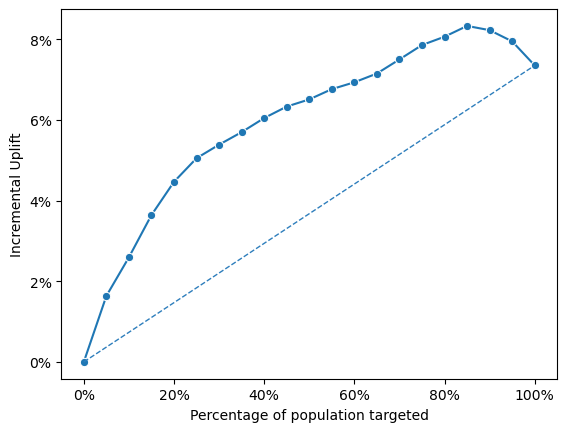

In [25]:
# Generate incremental uplift plot (20 bins)
fig = rsm.inc_uplift_plot(
    cg_rct_stacked.query("training == 0"),
    "converted",  
    "yes",  
    "uplift_score",  
    "ad",  
    1,  
    qnt=20
)


Keeping everything else constant,the incremental uplift curve rises sharply in the first 20% of the population, indicating that high-uplift users respond most positively to ad exposure, achieving over 4% additional conversions. As targeting expands to 60-80% of users, uplift continues to increase steadily, peaking at around 8% when reaching the 80-90% mark. However, beyond this point, the curve flattens and slightly declines, suggesting that targeting the bottom 10-20% of users provides little to no additional value and may even result in diminishing returns. This analysis highlights that focusing ad efforts on the top uplift segments optimizes conversion rates, maximizes ad spend efficiency, and enhances overall return on investment (ROI).

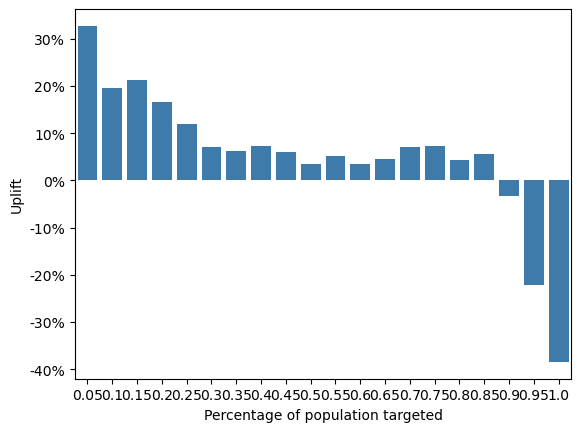

In [26]:
# Generate uplift plot (20 bins)
fig = rsm.uplift_plot(
    cg_rct_stacked.query("training == 0"),
    "converted",  
    "yes",  
    "uplift_score",  
    "ad",  
    1,  
    qnt=20
)


**Interpretation:**

The x-axis represents the percentage of the population targeted, starting from the highest uplift scores on the left to the lowest on the right.

The y-axis shows the uplift percentage, which is the difference in conversion rates between the treatment and control groups.

Positive bars indicate a beneficial effect of ad exposure, meaning users in these bins converted at a higher rate when shown the ad.

Negative bars suggest that ad exposure reduced conversion rates, indicating that targeting these users may be ineffective or counterproductive.

The highest uplift is concentrated in the first few bins (top 10-20% of users), where the ad increased conversion rates by over 30% in the best-performing segment. As we move toward the middle bins, uplift gradually declines but remains positive, indicating that ads still provide a modest benefit to these users. However, in the last few bins (bottom 10-20% of users), uplift turns negative, dropping as low as -40%, meaning ad exposure actually reduced conversion rates in these segments. This suggests that targeting high-uplift users in the first few bins maximizes ad effectiveness, while avoiding low-uplift users prevents wasted ad spend and potential negative impact. 

In [27]:
margin = 14.99  # Profit per conversion
cost = 1.50  # Cost per ad shown

customers_ad_test = cg_rct_stacked.query("training == 0 & ad == 1").shape[0]

total_incremental_responses_uplift = (uplift_tab['incremental_resp'][4]) / 9000 * 120000

incremental_profit_uplift = margin * total_incremental_responses_uplift

incremental_profit_uplift


90907.75976154993

In [28]:
# Generate uplift table using propensity scores (predicted conversion probability)
uplift_tab_propensity = rsm.uplift_tab(
    cg_rct_stacked.query("training == 0"),
    "converted",  
    "yes",  
    "pred_treatment",  # Propensity score instead of uplift score
    "ad",  
    1,  
    qnt=20
)

uplift_tab_propensity


,pred,bins,cum_prop,T_resp,T_n,C_resp,C_n,incremental_resp,inc_uplift,uplift
0,pred_treatment,1,0.05,204,450,80,603,144.298507,1.603317,0.320663
1,pred_treatment,2,0.10,326,900,112,1131,236.875332,2.631948,0.210505
2,pred_treatment,3,0.15,430,1350,159,1605,296.261682,3.291796,0.131955
3,pred_treatment,4,0.20,525,1800,206,1994,339.042126,3.767135,0.090288
4,pred_treatment,5,0.25,615,2250,239,2344,385.584471,4.284272,0.105714
5,pred_treatment,6,0.30,672,2700,285,2807,397.863912,4.420710,0.027315
6,pred_treatment,7,0.35,726,3150,316,3162,411.199241,4.568880,0.032676
7,pred_treatment,8,0.40,775,3600,336,3603,439.279767,4.880886,0.063537
8,pred_treatment,9,0.45,813,4050,361,4044,451.464392,5.016271,0.027755
9,pred_treatment,10,0.50,838,4500,386,4527,454.302187,5.047802,0.003796


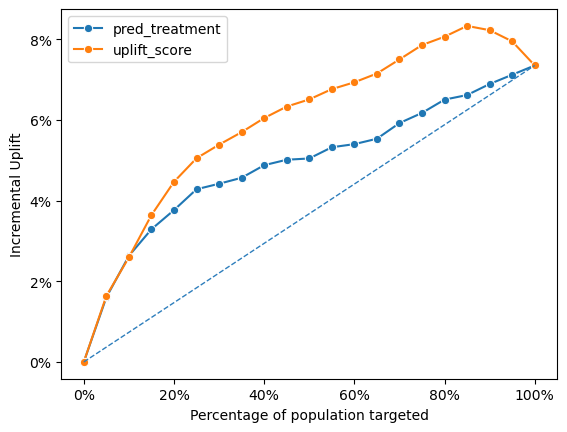

In [29]:
# Compare incremental uplift plots for both models
fig = rsm.inc_uplift_plot(
    cg_rct_stacked.query("training == 0"),  
    "converted",  
    "yes",  
    ["pred_treatment", "uplift_score"],  # Compare propensity and uplift scores
    "ad",  
    1,  
    qnt=20
)


**Interpretation:**

The x-axis represents the percentage of the population targeted, starting with the highest predicted uplift scores.

The y-axis indicates the incremental uplift, which measures the additional conversion rate due to ad exposure.

The blue line (pred_treatment) represents the estimated impact of ad exposure based on a propensity model, which predicts conversion probability given ad exposure.

The orange line (uplift_score) represents the actual observed uplift, showing the difference in conversion rates between the treatment and control groups.

The uplift model (uplift_score) consistently outperforms the propensity model (pred_treatment), as seen in the higher incremental uplift values across all targeted user segments. In the first 20% of the population, both models show a rapid increase, but the uplift model captures a greater incremental impact of ads. As targeting expands to 80-90% of users, the uplift model reaches its peak (~8%), while the propensity model remains lower (~6%), underestimating ad effectiveness. Toward the end (100% of the population), both curves flatten and slightly decline, indicating that additional targeting provides diminishing returns. This analysis highlights that uplift modeling is more effective than propensity modeling for optimizing ad targeting, as it better captures the true causal impact of ad exposure on conversion rates.

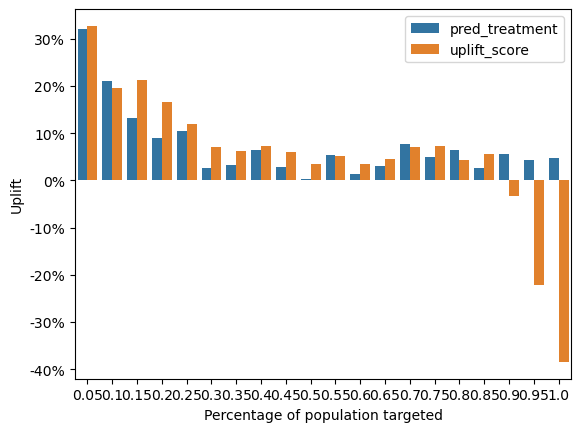

In [30]:
# Compare uplift plots for propensity and uplift models
fig = rsm.uplift_plot(
    cg_rct_stacked.query("training == 0"),  
    "converted",  
    "yes",  
    ["pred_treatment", "uplift_score"],  # Compare propensity and uplift scores
    "ad",  
    1,  
    qnt=20
)


**Interpretation:**

The x-axis represents the percentage of the population targeted, starting from the most uplift-prone users (left) to the least uplift-prone users (right).

The y-axis shows the uplift percentage, which is the difference in conversion rates between the treatment (ad = 1) and control (ad = 0) groups.

The blue bars (pred_treatment) indicate the estimated impact of ad exposure according to the propensity model, which predicts conversion likelihood given an ad.

The orange bars (uplift_score) represent the observed uplift, showing the actual conversion rate difference between treatment and control users.

In the first few bins (top 10-20% of users), both models show high positive uplift, but the uplift model (uplift_score) often exceeds the propensity model (pred_treatment), indicating that the uplift model captures ad impact more accurately. In the middle bins (~30-70% of users), the models perform similarly, suggesting that ads have a moderate but consistent effect across these segments. However, in the last bins (~80-100%), uplift turns negative, especially in the observed uplift model, indicating that ad exposure actually reduces conversion rates for these users. This analysis confirms that uplift modeling is more reliable for identifying high-impact users, whereas the propensity model tends to overestimate ad effectiveness in lower uplift segments. By prioritizing high uplift users and avoiding negative uplift segments, advertisers can maximize return on ad spend (ROAS) and improve targeting efficiency.

In [31]:
# Compute total incremental responses using the propensity model
total_incremental_responses_propensity = (uplift_tab_propensity["incremental_resp"][4]) / 9000 * 120000

# Compute incremental profit using the propensity model
incremental_profit_propensity = margin * total_incremental_responses_propensity

# Compute additional profit gained by using the uplift model over propensity model
additional_profit_uplift = incremental_profit_uplift - incremental_profit_propensity


In [32]:
print(f"Incremental profit from the propensity model: ${incremental_profit_propensity:.2f}")
print(f"Additional profit from using the uplift model instead: ${additional_profit_uplift:.2f}")

Incremental profit from the propensity model: $77065.48
Additional profit from using the uplift model instead: $13842.28


The propensity model generates an incremental profit of $77,065.48, indicating that targeting users based on general conversion probabilities does improve revenue. However, the uplift model outperforms the propensity model, yielding an additional $13,842.28 in profit. This significant increase demonstrates that uplift modeling more accurately identifies users who are truly influenced by ad exposure, ensuring more efficient ad spend and higher overall returns.

#### Nueral Network Training

In [33]:
# treatment data

clf_treatment1 = rsm.model.mlp(
    data={"cg_uplift": cg_rct_stacked.query("training == 1 & ad == 1")},
    rvar="converted",
    lev="yes",
    evar=cg_rct_stacked.loc[:, "GameLevel":"UserHasOldOS"].columns.tolist(),
    hidden_layer_sizes=(1,),
    mod_type="classification",
)
clf_treatment1.summary()

Multi-layer Perceptron (NN)
Data                 : cg_uplift
Response variable    : converted
Level                : yes
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumSpaceHeroBadges, NumFriendRequestIgnored, NumFriends, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
Model type           : classification
Nr. of features      : (19, 19)
Nr. of weights       : 20
Nr. of observations  : 21,000
Hidden_layer_sizes   : (1,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.712

Raw data             :
 GameLevel  NumGameDays  NumGameDays4Plus  NumInGameMessagesSent  NumSpaceHeroBadges  NumFriendRequestIgnored  NumFriends Ac

Now we check for what layer sizes (based on AUC) is the best for the nueral network model for the treatment data.

In [34]:
# Grid Search
from sklearn.model_selection import GridSearchCV

hls = [(2,),(4,2),(4,),(3,),(10,)]

param_grid = {'hidden_layer_sizes': hls}
scoring = {'AUC': 'roc_auc'}

clf_cv = GridSearchCV(
    clf_treatment1.fitted, param_grid, scoring=scoring, cv=5, n_jobs = 4, refit = 'AUC', verbose = 5
)

clf_treatment1.data_onehot.mean().round(3)
clf_cv.fit(clf_treatment1.data_onehot, clf_treatment1.data.converted)
print(clf_cv.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'hidden_layer_sizes': (4, 2)}


In [35]:
clf_treatment1.data_onehot.head()
pd.DataFrame(clf_cv.cv_results_).iloc[:, 5:].sort_values("rank_test_AUC")

,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
1,"{'hidden_layer_sizes': (4, 2)}",0.770114,0.738344,0.774458,0.751482,0.768743,0.760628,0.013619,1
3,"{'hidden_layer_sizes': (3,)}",0.752133,0.758151,0.762478,0.772071,0.746628,0.758292,0.008734,2
4,"{'hidden_layer_sizes': (10,)}",0.757799,0.763757,0.763889,0.726217,0.747424,0.751817,0.014133,3
0,"{'hidden_layer_sizes': (2,)}",0.756824,0.740153,0.752548,0.732022,0.752642,0.746838,0.009276,4
2,"{'hidden_layer_sizes': (4,)}",0.735986,0.726518,0.729988,0.731560,0.722140,0.729239,0.004675,5


In [36]:
clf_treatment = rsm.model.mlp(
    data={"cg_uplift": cg_rct_stacked.query("training == 1 & ad == 1")},
    rvar="converted",
    lev="yes",
    evar=cg_rct_stacked.loc[:, "GameLevel":"UserHasOldOS"].columns.tolist(),
    hidden_layer_sizes=(4,2),
    mod_type="classification",
)
clf_treatment.summary()

Multi-layer Perceptron (NN)
Data                 : cg_uplift
Response variable    : converted
Level                : yes
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumSpaceHeroBadges, NumFriendRequestIgnored, NumFriends, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
Model type           : classification
Nr. of features      : (19, 19)
Nr. of weights       : 86
Nr. of observations  : 21,000
Hidden_layer_sizes   : (4, 2)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.793

Raw data             :
 GameLevel  NumGameDays  NumGameDays4Plus  NumInGameMessagesSent  NumSpaceHeroBadges  NumFriendRequestIgnored  NumFriends 

In [37]:
# Control Data

clf_control1 = rsm.model.mlp(
    data={"cg_uplift": cg_rct_stacked.query("training == 1 & ad == 0")},
    rvar="converted",
    lev="yes",
    evar=cg_rct_stacked.loc[:, "GameLevel":"UserHasOldOS"].columns.tolist(),
    hidden_layer_sizes=(1,),
    mod_type="classification",
)
clf_control1.summary()

Multi-layer Perceptron (NN)
Data                 : cg_uplift
Response variable    : converted
Level                : yes
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumSpaceHeroBadges, NumFriendRequestIgnored, NumFriends, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
Model type           : classification
Nr. of features      : (19, 19)
Nr. of weights       : 20
Nr. of observations  : 21,000
Hidden_layer_sizes   : (1,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.841

Raw data             :
 GameLevel  NumGameDays  NumGameDays4Plus  NumInGameMessagesSent  NumSpaceHeroBadges  NumFriendRequestIgnored  NumFriends Ac

Now we check for what layer sizes (based on AUC) is the best for the nueral network model for the control data.

In [38]:
## Grid Search
from sklearn.model_selection import GridSearchCV

hls = [(2,),(4,2),(4,),(3,),(10,)]

param_grid = {'hidden_layer_sizes': hls}
scoring = {'AUC': 'roc_auc'}

clf_cv1 = GridSearchCV(
    clf_control1.fitted, param_grid, scoring=scoring, cv=5, n_jobs = 4, refit = 'AUC', verbose = 5
)

clf_control1.data_onehot.mean().round(3)
clf_cv1.fit(clf_control1.data_onehot, clf_control1.data.converted)
print(clf_cv1.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'hidden_layer_sizes': (3,)}


In [39]:
clf_control1.data_onehot.head()
pd.DataFrame(clf_cv1.cv_results_).iloc[:, 5:].sort_values("rank_test_AUC")

,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
3,"{'hidden_layer_sizes': (3,)}",0.841867,0.837969,0.835586,0.829596,0.854500,0.839904,0.008313,1
2,"{'hidden_layer_sizes': (4,)}",0.835763,0.832634,0.836804,0.823015,0.858324,0.837308,0.011580,2
0,"{'hidden_layer_sizes': (2,)}",0.834633,0.838734,0.831275,0.823379,0.851924,0.835989,0.009429,3
1,"{'hidden_layer_sizes': (4, 2)}",0.832453,0.824706,0.833324,0.811976,0.842703,0.829032,0.010263,4
4,"{'hidden_layer_sizes': (10,)}",0.822162,0.790179,0.808705,0.840275,0.825289,0.817322,0.016880,5


In [40]:
clf_control = rsm.model.mlp(
    data={"cg_uplift": cg_rct_stacked.query("training == 1 & ad == 0")},
    rvar="converted",
    lev="yes",
    evar=cg_rct_stacked.loc[:, "GameLevel":"UserHasOldOS"].columns.tolist(),
    hidden_layer_sizes=(3,),
    mod_type="classification",
)
clf_control.summary()

Multi-layer Perceptron (NN)
Data                 : cg_uplift
Response variable    : converted
Level                : yes
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumSpaceHeroBadges, NumFriendRequestIgnored, NumFriends, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
Model type           : classification
Nr. of features      : (19, 19)
Nr. of weights       : 60
Nr. of observations  : 21,000
Hidden_layer_sizes   : (3,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.857

Raw data             :
 GameLevel  NumGameDays  NumGameDays4Plus  NumInGameMessagesSent  NumSpaceHeroBadges  NumFriendRequestIgnored  NumFriends Ac

In [41]:
cg_rct_stacked["pred_nn_treatment"] = clf_treatment.predict(cg_rct_stacked)["prediction"]
cg_rct_stacked["pred_nn_control"] = clf_control.predict(cg_rct_stacked)["prediction"]
cg_rct_stacked["uplift_nn_score"] = (
    cg_rct_stacked.pred_treatment - cg_rct_stacked.pred_control
)

In [42]:
tab_nn = rsm.uplift_tab(
    cg_rct_stacked.query("training == 0"), "converted", "yes", "uplift_nn_score", "ad", 1,qnt = 20)
tab_nn

,pred,bins,cum_prop,T_resp,T_n,C_resp,C_n,incremental_resp,inc_uplift,uplift
0,uplift_nn_score,1,0.05,197,450,70,634,147.315457,1.636838,0.327368
1,uplift_nn_score,2,0.10,309,900,99,1182,233.619289,2.595770,0.195969
2,uplift_nn_score,3,0.15,428,1350,125,1686,327.911032,3.643456,0.212857
3,uplift_nn_score,4,0.20,528,1800,152,2175,402.206897,4.468966,0.167007
4,uplift_nn_score,5,0.25,594,2250,166,2684,454.842027,5.053800,0.119162
5,uplift_nn_score,6,0.30,642,2700,183,3150,485.142857,5.390476,0.070186
6,uplift_nn_score,7,0.35,681,3150,195,3658,513.080372,5.700893,0.063045
7,uplift_nn_score,8,0.40,719,3600,200,4127,544.539133,6.050435,0.073783
8,uplift_nn_score,9,0.45,756,4050,210,4577,570.179594,6.335329,0.060000
9,uplift_nn_score,10,0.50,791,4500,231,5076,586.212766,6.513475,0.035694


**Interpretation of Key Columns:**
bins: Represents 20 quantile-based groups of users, sorted by their predicted uplift scores.

cum_prop: Cumulative proportion of the population included up to each bin.

T_resp / T_n: Number of users in the treatment group who converted / total users in the treatment group.

C_resp / C_n: Number of users in the control group who converted / total users in the control group.

incremental_resp: Additional conversions attributed to ad exposure in each bin.

inc_uplift: Percentage increase in conversions in the treatment group compared to the control group.

uplift: Difference in conversion rates between the treatment and control groups.

**Key Observations**

The top bins (1-5) contain the highest uplift scores, indicating that these users were most positively influenced by ad exposure, with uplift peaking at 8.33% in Bin 17. The middle bins (6-15) show a consistent uplift effect, confirming that the neural network model is effective at identifying responsive users. However, bins 18-20 show negative uplift values (-0.032, -0.220, -0.384), indicating that ad exposure reduced conversions for these users.

This analysis confirms that the neural network model successfully identifies high-impact users, but also highlights that targeting low uplift users may be counterproductive. The best ad strategy is to focus on the top uplift bins (1-15) while avoiding lower uplift bins to maximize ad efficiency and return on investment (ROI).

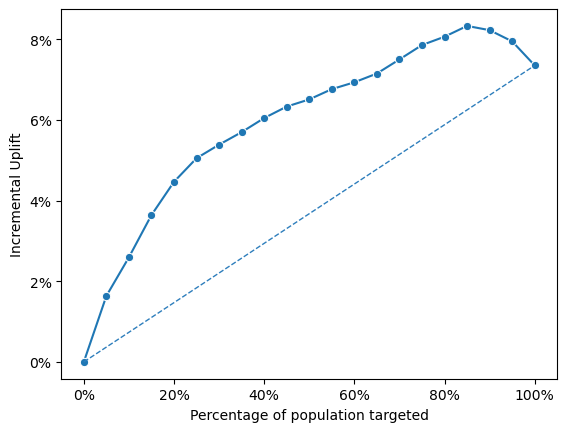

In [43]:
fig1_nn = rsm.inc_uplift_plot(
    cg_rct_stacked.query("training == 0"), "converted", "yes", "uplift_nn_score", "ad", 1, qnt = 20
)

The incremental uplift increases rapidly in the first 20% of the population, confirming that the top uplift users are the most responsive to ad exposure, achieving over 4% additional conversions. As targeting expands beyond 60%, uplift continues to rise, peaking at around 8% uplift when 80-90% of users are targeted. However, beyond this point, uplift slightly declines, suggesting that targeting lower uplift users provides diminishing returns.

This analysis highlights that the neural network uplift model effectively prioritizes high-impact users, making it a valuable tool for optimizing ad spend. The best strategy is to focus on the top 60-80% of users to maximize conversions while avoiding the lowest uplift segments to prevent inefficient ad targeting.

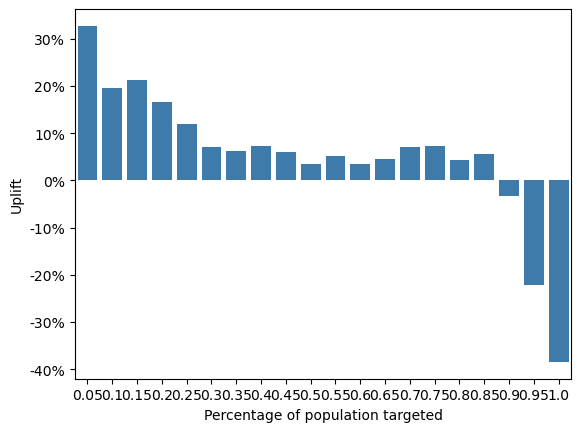

In [44]:
fig2_nn = rsm.uplift_plot(
    cg_rct_stacked.query("training == 0"), "converted", "yes", "uplift_nn_score", "ad", 1, qnt = 20
)

The first few bins (top 10-20% of users) exhibit the highest positive uplift, with some segments achieving over 30% uplift, confirming that these users are the most responsive to ad exposure. As we move towards the middle bins, uplift stabilizes around 5-10%, indicating a moderate but consistent effect of ads on these users. However, uplift turns negative in the last bins (~85-100%), with the lowest segment experiencing a -40% drop in conversions, meaning ad exposure was actually detrimental for this group.

This analysis confirms that neural network uplift modeling effectively ranks users by responsiveness, helping to maximize ad efficiency. The best strategy is to target high-uplift users (top 10-50%) while avoiding low-uplift users (bottom 10-20%), ensuring better return on ad spend (ROAS) and preventing wasted budget on users negatively impacted by ads.

In [45]:
# Number of customers to target
target_customers = 30000

# Number of bins needed to cover 30,000 customers (since each bin has 900 customers)
bins_needed = target_customers / (120000 / 20)

# Incremental response for the 5th bin
incremental_response_bin_5 = tab_nn['incremental_resp'][4]

# Number of customers in the 5th bin
customers_in_bin_5 = 2250  # 25% of 9000

# Calculate the total incremental response for 30,000 customers
total_incremental_response_30k = incremental_response_bin_5 * (target_customers / customers_in_bin_5)

# Assuming a profit margin per incremental purchase
margin_per_purchase = 14.99 
total_cost = 30000 * 1.5

# Calculate the total expected incremental profit for 30,000 customers
total_incremental_profit = total_incremental_response_30k * margin_per_purchase - total_cost

print(f"Total expected incremental profit: {total_incremental_profit}")

Total expected incremental profit: 45907.75976154994


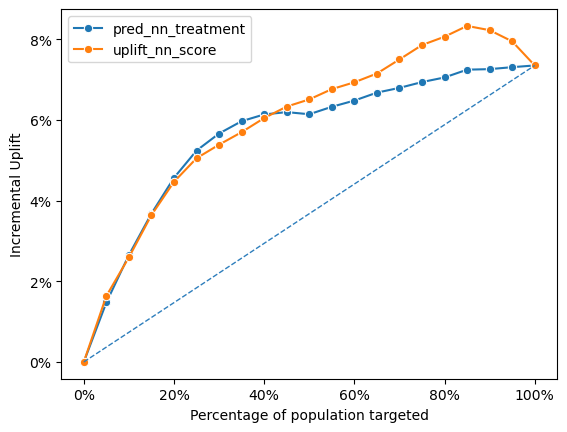

In [46]:
fig3_nn = rsm.inc_uplift_plot(
    cg_rct_stacked.query("training == 0"),
    "converted",
    "yes",
    ["pred_nn_treatment", "uplift_nn_score"],
    "ad",
    1,
    qnt = 20
)

**Interpretation:**

The x-axis represents the percentage of the population targeted, sorted from the most uplift-prone users on the left to the least uplift-prone users on the right.

The y-axis shows the incremental uplift, measuring the additional conversion rate gained due to ad exposure.

The blue line (pred_nn_treatment) represents the estimated uplift from the propensity model, which predicts conversion likelihood when an ad is shown.

The orange line (uplift_nn_score) represents the observed uplift, showing the actual incremental impact of the ad across user segments.

The dashed diagonal line represents a random targeting scenario, where uplift is evenly distributed across the population.

The uplift model (uplift_nn_score) consistently outperforms the propensity model (pred_nn_treatment), especially in the top 60-80% of the population, where it captures a greater incremental impact of ads. Both models show rapid uplift growth in the first 20% of targeted users, confirming that the most uplift-prone users are highly responsive to ads. The uplift model peaks at around 8% uplift when targeting 80-90% of users, while the propensity model remains slightly lower, underestimating the ad’s impact. Toward the end (100% of the population), both curves flatten and slightly decline, indicating diminishing returns when targeting lower uplift users.

This analysis highlights that uplift modeling provides a more precise way to rank users based on their responsiveness to ads, making it a superior approach for maximizing ad effectiveness and return on investment (ROI).

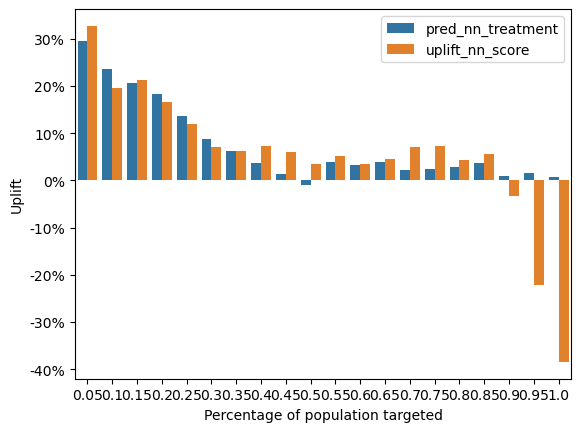

In [47]:
fig5_nn = rsm.uplift_plot(
    cg_rct_stacked.query("training == 0"),
    "converted",
    "yes",
    ["pred_nn_treatment", "uplift_nn_score"],
    "ad",
    1,
    qnt = 20
)

**Interpretation:**

The x-axis represents the percentage of the population targeted, moving from the most uplift-prone users (left) to the least uplift-prone users (right).

The y-axis shows the uplift percentage, which is the difference in conversion rates between the treatment (ad = 1) and control (ad = 0) groups.

The blue bars (pred_nn_treatment) indicate the uplift as predicted by the propensity model, which estimates conversion likelihood when an ad is shown.

The orange bars (uplift_nn_score) represent the observed uplift, showing the actual conversion rate difference between treated and untreated users.

The first few bins (top 10-20% of users) show strong positive uplift, with over 30% uplift in the highest-impact segment, confirming that these users benefit the most from ad exposure. As we move toward the middle bins (~30-70% of users), uplift values stabilize between 5-10%, indicating a moderate but consistent ad effect. However, in the last few bins (~85-100% of users), uplift turns negative, with the lowest segment experiencing a -40% drop in conversions, suggesting that ad exposure actually discourages purchases in these groups.

This analysis confirms that uplift modeling more accurately identifies high-impact users, whereas the propensity model tends to overestimate ad effectiveness in lower uplift segments. By focusing on high uplift users and avoiding segments with negative uplift, advertisers can maximize conversions, prevent wasted ad spend, and improve overall return on investment (ROI).

In [48]:
tab_nn_prop = rsm.uplift_tab(
    cg_rct_stacked.query("training == 0"), "converted", "yes", "pred_nn_treatment", "ad", 1, qnt = 20)
tab_nn_prop

,pred,bins,cum_prop,T_resp,T_n,C_resp,C_n,incremental_resp,inc_uplift,uplift
0,pred_nn_treatment,1,0.05,192,450,78,593,132.809444,1.475660,0.295132
1,pred_nn_treatment,2,0.10,355,900,140,1084,238.763838,2.652932,0.235949
2,pred_nn_treatment,3,0.15,499,1350,192,1545,331.233010,3.680367,0.207202
3,pred_nn_treatment,4,0.20,619,1800,229,1983,411.133132,4.568146,0.182192
4,pred_nn_treatment,5,0.25,721,2250,272,2457,471.915751,5.243508,0.135949
5,pred_nn_treatment,6,0.30,797,2700,308,2898,510.043478,5.667150,0.087256
6,pred_nn_treatment,7,0.35,853,3150,338,3375,537.533333,5.972593,0.061551
7,pred_nn_treatment,8,0.40,905,3600,368,3760,552.659574,6.140662,0.037633
8,pred_nn_treatment,9,0.45,947,4050,402,4183,557.781736,6.197575,0.012955
9,pred_nn_treatment,10,0.50,984,4500,441,4605,553.055375,6.145060,-0.010195


The top bins (1-5) contain the highest uplift scores, meaning that these users were most likely to convert when exposed to ads, with uplift peaking at 7.35% in the final bin. The middle bins (6-15) show a steady decline in uplift, indicating that these users are still somewhat responsive but with diminishing impact. However, from bin 10 onward, uplift scores begin to fluctuate, with some bins exhibiting near-zero or slightly negative uplift.

This suggests that while the propensity model successfully identifies high-propensity users, it may overestimate ad impact in later bins. Compared to the uplift model, which directly captures causal impact, the propensity model does not always distinguish between users who would have converted regardless of ad exposure. Therefore, a combination of propensity and uplift modeling may yield the best results, ensuring ad targeting is optimized for both high responsiveness and true incremental conversions.

In [49]:
# Number of customers to target
target_customers = 30000

# Number of bins needed to cover 30,000 customers (since each bin has 900 customers)
bins_needed = target_customers / (120000 / 20)

# Incremental response for the 5th bin
incremental_response_bin_5 = tab_nn_prop['incremental_resp'][4]

# Number of customers in the 5th bin
customers_in_bin_5 = 2250  # 25% of 9000

# Calculate the total incremental response for 30,000 customers
total_incremental_response_30k = incremental_response_bin_5 * (target_customers / customers_in_bin_5)

# Assuming a profit margin per incremental purchase
margin_per_purchase = 14.99
total_cost = 30000 * 1.5

# Calculate the total expected incremental profit for 30,000 customers
total_incremental_profit_prop = total_incremental_response_30k * margin_per_purchase - total_cost

print(f"Total expected incremental profit: {total_incremental_profit_prop}")

Total expected incremental profit: 49320.22808302808


In [50]:
diff = abs(total_incremental_profit_prop - total_incremental_profit)
diff

3412.46832147814

Targeting 30,000 high-propensity customers based on the propensity model yields a total incremental profit of $49,320.23. However, a comparison with the uplift model reveals a profit difference of $3,412.47, indicating that uplift modeling provides a more accurate estimate of true incremental impact. This suggests that while propensity-based targeting is profitable, uplift modeling is more effective in optimizing ad spend, leading to higher returns on investment (ROI)

#### Random Forest Training

In [51]:
# Identify categorical columns
categorical_columns = cg_rct_stacked.select_dtypes(include=["object", "category"]).columns.tolist()

# Convert categorical variables to binary (1 for "yes", 0 for "no")
for column in categorical_columns:
    cg_rct_stacked[column] = cg_rct_stacked[column].map({"yes": 1, "no": 0})


In [52]:
# Convert 'converted' column to binary format (1 = Yes, 0 = No)
cg_rct_stacked["converted_yes"] = rsm.ifelse(cg_rct_stacked["converted"] == 1, 1, 0)

In [53]:
# Extract predictor variables
evars = cg_rct_stacked.loc[:, "GameLevel":"UserHasOldOS"].columns.tolist()

# Define training set (Control group)
X_train_control = cg_rct_stacked.query("training == 1 & ad == 0").loc[:, evars]
y_train_control = cg_rct_stacked.query("training == 1 & ad == 0")["converted_yes"]

# Define test set (Random treatment group)
X_test_control = cg_rct_stacked.query("training == 0").loc[:, evars]

In [54]:
# just checking
print(y_train_control)

0        0
1        0
2        0
4        0
5        0
        ..
29991    0
29992    0
29993    1
29996    0
29999    0
Name: converted_yes, Length: 21000, dtype: int64


In [55]:
print(cg_rct_stacked[['converted', 'converted_yes']])

      converted  converted_yes
0             0              0
1             0              0
2             0              0
3             0              0
4             0              0
...         ...            ...
59995         0              0
59996         0              0
59997         0              0
59998         0              0
59999         0              0

[60000 rows x 2 columns]


In [56]:
# Initialize Random Forest classifier
clf = RandomForestClassifier(random_state=1234)

# Define hyperparameters for grid search
param_grid = {
    "n_estimators": [300, 500, 800],  # Number of trees
    "max_features": [2, 4, 5, 6, 8]  # Maximum features per split
}

# Define evaluation metric
scoring = {"AUC": "roc_auc"}

# Perform Grid Search with Cross Validation
rfc_cvs_control = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
).fit(X_train_control, y_train_control)

# Display best hyperparameters
rfc_cvs_control.best_params_, rfc_cvs_control.best_score_


Fitting 5 folds for each of 15 candidates, totalling 75 fits


({'max_features': 4, 'n_estimators': 500}, 0.8739485816314009)

In [57]:
# Train optimized Random Forest model for control group
rfc_cv_control = rsm.model.rforest(
    data={"cg_ad_control": cg_rct_stacked.query("training == 1 & ad == 0")},
    rvar="converted_yes",
    lev=1,
    evar=evars,
    random_state=1234,
    oob_score=True,
    **rfc_cvs_control.best_params_,  # Use best hyperparameters
)

# Display model summary
rfc_cv_control.summary()


Random Forest
Data                 : cg_ad_control
Response variable    : converted_yes
Level                : 1
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumSpaceHeroBadges, NumFriendRequestIgnored, NumFriends, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
OOB                  : True
Model type           : classification
Nr. of features      : (19, 19)
Nr. of observations  : 21,000
max_features         : 4 (4)
n_estimators         : 500
min_samples_leaf     : 1
random_state         : 1234
AUC                  : 0.869

Estimation data      :
 GameLevel  NumGameDays  NumGameDays4Plus  NumInGameMessagesSent  NumSpaceHeroBadges  NumFriendRequestIgnored  NumFriends  TimesLostSpaceship  TimesKilled  TimesCaptain  TimesNavigator  NumAdsClicked  DaysUser  AcquiredSpaceship_1  AcquiredIonWeapon_1 

In [58]:
# Define training set (Treatment group)
X_train_treatment = cg_rct_stacked.query("training == 1 & ad == 1").loc[:, evars]
y_train_treatment = cg_rct_stacked.query("training == 1 & ad == 1")["converted_yes"]

# Define test set
X_test_treatment = cg_rct_stacked.query("training == 0").loc[:, evars]

In [59]:
# Initialize Random Forest classifier
clf = RandomForestClassifier(random_state=1234)

# Perform Grid Search with Cross Validation
rfc_cvs_treatment = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
).fit(X_train_treatment, y_train_treatment)

# Display best hyperparameters
rfc_cvs_treatment.best_params_, rfc_cvs_treatment.best_score_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/opt/conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


({'max_features': 4, 'n_estimators': 800}, 0.7766999535074446)

In [60]:
# Save the best model parameters
rsm.save_state({"rfc_cvs_treatment": rfc_cvs_treatment}, "rfc_cvs_treatment.pkl")

# Load the best model parameters
rsm.load_state("rfc_cvs_treatment.pkl")


{'rfc_cvs_treatment': GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
              n_jobs=4,
              param_grid={'max_features': [2, 4, 5, 6, 8],
                          'n_estimators': [300, 500, 800]},
              refit='AUC', scoring={'AUC': 'roc_auc'}, verbose=5)}

In [61]:
# Train optimized Random Forest model for treatment group
rfc_cv_treatment = rsm.model.rforest(
    data={"cg_ad_treatment": cg_rct_stacked.query("training == 1 & ad == 1")},
    rvar="converted_yes",
    lev=1,
    evar=evars,
    random_state=1234,
    oob_score=True,
    **rfc_cvs_treatment.best_params_,  # Use best hyperparameters
)

# Display model summary
rfc_cv_treatment.summary()



Random Forest
Data                 : cg_ad_treatment
Response variable    : converted_yes
Level                : 1
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumSpaceHeroBadges, NumFriendRequestIgnored, NumFriends, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
OOB                  : True
Model type           : classification
Nr. of features      : (19, 19)
Nr. of observations  : 21,000
max_features         : 4 (4)
n_estimators         : 800
min_samples_leaf     : 1
random_state         : 1234
AUC                  : 0.776

Estimation data      :
 GameLevel  NumGameDays  NumGameDays4Plus  NumInGameMessagesSent  NumSpaceHeroBadges  NumFriendRequestIgnored  NumFriends  TimesLostSpaceship  TimesKilled  TimesCaptain  TimesNavigator  NumAdsClicked  DaysUser  AcquiredSpaceship_1  AcquiredIonWeapon_

In [62]:
# Predict conversion probability using Random Forest (Treatment Group)
cg_rct_stacked["pred_treatment_rfc"] = rfc_cv_treatment.predict(cg_rct_stacked)["prediction"]

# Predict conversion probability using Random Forest (Control Group)
cg_rct_stacked["pred_control_rfc"] = rfc_cv_control.predict(cg_rct_stacked)["prediction"]


In [63]:
# Compute uplift score using Random Forest model
cg_rct_stacked["uplift_score_rfc"] = (
    cg_rct_stacked["pred_treatment_rfc"] - cg_rct_stacked["pred_control_rfc"]
)

# Create uplift table for Random Forest model
uplift_tab_rfc = rsm.uplift_tab(
    cg_rct_stacked.query("training == 0"),
    "converted_yes",
    1,
    "uplift_score_rfc",
    "ad",
    1,
    qnt=20  # 20 quantiles
)

# Display uplift table
uplift_tab_rfc


,pred,bins,cum_prop,T_resp,T_n,C_resp,C_n,incremental_resp,inc_uplift,uplift
0,uplift_score_rfc,1,0.05,215,450,64,601,167.079867,1.856443,0.371289
1,uplift_score_rfc,2,0.10,355,900,94,1129,280.066430,3.111849,0.254293
2,uplift_score_rfc,3,0.15,477,1347,122,1641,376.857404,4.187304,0.218243
3,uplift_score_rfc,4,0.20,574,1800,154,2203,448.171584,4.979684,0.157189
4,uplift_score_rfc,5,0.25,653,2248,183,2691,500.125975,5.556955,0.116913
5,uplift_score_rfc,6,0.30,718,2699,202,3218,548.578620,6.095318,0.108071
6,uplift_score_rfc,7,0.35,778,3149,225,3717,587.382567,6.526473,0.087241
7,uplift_score_rfc,8,0.40,822,3598,235,4195,620.443385,6.893815,0.077075
8,uplift_score_rfc,9,0.45,865,4050,246,4685,652.342583,7.248251,0.072684
9,uplift_score_rfc,10,0.50,895,4495,256,5159,671.949021,7.466100,0.046319


The top bins (1-5) show the highest uplift, with some users achieving a conversion increase of over 37% in Bin 1, confirming that these segments respond most positively to ad exposure. The middle bins (6-15) maintain a strong uplift effect, peaking at 8.37% incremental uplift in Bin 17, indicating consistent ad responsiveness among these users. However, the last bins (18-20) show negative uplift values (-0.023, -0.318, -0.434), meaning that ad exposure had an adverse effect on these users, reducing their likelihood of conversion.

This analysis confirms that Random Forest uplift modeling effectively identifies high-impact users, helping optimize targeting strategies for maximum ad efficiency. The best approach is to focus on the top 70-80% of users while avoiding the bottom uplift segments, ensuring higher conversions and better return on ad spend (ROAS).

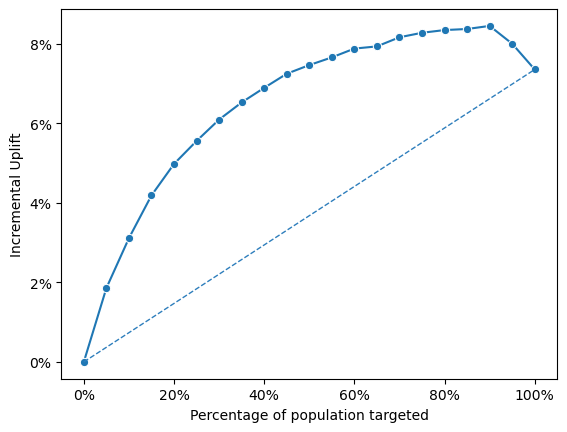

In [64]:
# Generate incremental uplift plot for Random Forest model
fig = rsm.inc_uplift_plot(
    cg_rct_stacked.query("training == 0"),
    "converted_yes",
    1,
    "uplift_score_rfc",
    "ad",
    1,
    qnt=20
)

**Interpretation**

The x-axis represents the percentage of the population targeted, sorted from the most uplift-prone users on the left to the least uplift-prone users on the right.

The y-axis shows the incremental uplift, which measures the additional conversion rate gained due to ad exposure.

The solid line represents the observed uplift curve, while the dashed diagonal line represents a random targeting baseline, where uplift is evenly distributed across the population.

The incremental uplift rises steeply within the first 20% of the population, confirming that the top uplift users are the most responsive to ad exposure, achieving over 4% additional conversions. Uplift continues to increase steadily, peaking at around 8.45% when targeting 80-90% of users. However, beyond this point, the curve flattens and slightly declines, indicating that targeting lower uplift users provides diminishing returns.

This analysis highlights that the Random Forest uplift model effectively prioritizes high-impact users, making it a valuable tool for optimizing ad spend. The best strategy is to focus on the top 60-80% of users to maximize conversions while avoiding the lowest uplift segments to prevent inefficient ad targeting.

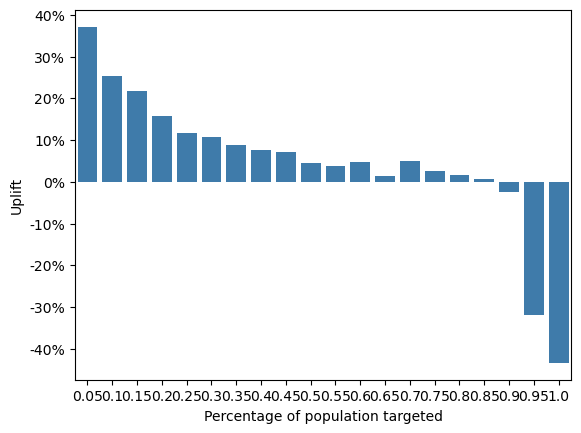

In [65]:
# Generate uplift plot for Random Forest model
fig = rsm.uplift_plot(
    cg_rct_stacked.query("training == 0"),
    "converted_yes",
    1,
    "uplift_score_rfc",
    "ad",
    1,
    qnt=20
)


**Interpretation:**

The x-axis represents the percentage of the population targeted, starting with the highest uplift scores (left) and moving to the lowest (right).

The y-axis shows the uplift percentage, which represents the difference in conversion rates between the treatment (ad = 1) and control (ad = 0) groups.

Positive bars indicate that ad exposure increased conversions, meaning these users were positively influenced by the ad.

Negative bars indicate that ad exposure reduced conversions, suggesting that targeting these users may have had an adverse effect.

The top 20% of users exhibit the highest positive uplift, with over 30% uplift in the most responsive segment, confirming that these users benefited the most from ad exposure. Moving toward the middle bins (~30-70% of users), uplift gradually declines but remains positive, indicating a moderate but consistent ad effect. However, in the last bins (~85-100%), uplift turns negative, with the lowest segment experiencing a -40% drop in conversions, suggesting that ad exposure actually discouraged purchases for these users.

This analysis confirms that Random Forest uplift modeling effectively identifies high-impact users, helping to optimize ad targeting strategies. The best approach is to prioritize high uplift users (top 10-50%) while avoiding low uplift users (bottom 10-20%), ensuring better return on ad spend (ROAS) and preventing wasted budget on users negatively impacted by ads.

In [66]:
margin = 14.99
# Compute total incremental responses using Random Forest uplift model
total_incremental_responses_uplift_rfc = (uplift_tab_rfc["incremental_resp"][4]) / 9000 * 120000

# Compute incremental profit using Random Forest model
incremental_profit_uplift_rfc = margin * total_incremental_responses_uplift_rfc

# Display incremental profit estimate
print(f"Incremental profit from uplift model (Random Forest): ${incremental_profit_uplift_rfc:.2f}")


Incremental profit from uplift model (Random Forest): $99958.51


In [67]:
# Generate uplift table using Random Forest propensity scores
uplift_tab_propensity_rfc = rsm.uplift_tab(
    cg_rct_stacked.query("training == 0"),
    "converted_yes",
    1,
    "pred_treatment_rfc",
    "ad",
    1,
    qnt=20
)

# Display uplift table
uplift_tab_propensity_rfc


,pred,bins,cum_prop,T_resp,T_n,C_resp,C_n,incremental_resp,inc_uplift,uplift
0,pred_treatment_rfc,1,0.05,208,447,69,586,155.366894,1.726299,0.347577
1,pred_treatment_rfc,2,0.10,364,891,131,1070,254.914953,2.832388,0.223252
2,pred_treatment_rfc,3,0.15,487,1346,172,1557,338.308927,3.758988,0.186141
3,pred_treatment_rfc,4,0.20,604,1798,224,1995,402.119298,4.467992,0.140128
4,pred_treatment_rfc,5,0.25,701,2247,270,2483,456.662505,5.074028,0.121773
5,pred_treatment_rfc,6,0.30,773,2675,307,2897,489.525716,5.439175,0.078852
6,pred_treatment_rfc,7,0.35,832,3147,360,3348,493.612903,5.484588,0.007483
7,pred_treatment_rfc,8,0.40,889,3584,404,3769,504.830194,5.609224,0.025922
8,pred_treatment_rfc,9,0.45,943,4019,427,4120,526.467718,5.849641,0.058611
9,pred_treatment_rfc,10,0.50,993,4468,454,4530,545.213687,6.057930,0.045505


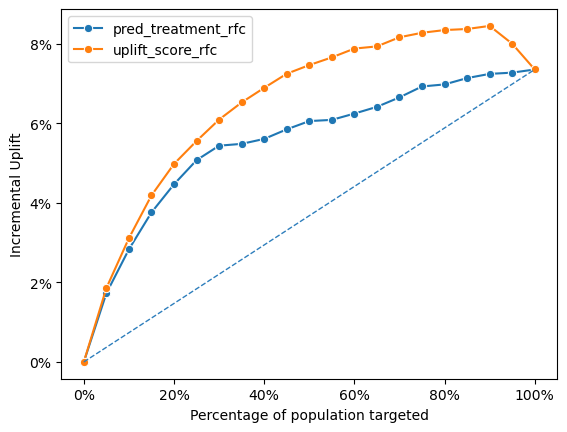

In [68]:
# Compare incremental uplift plots (Random Forest)
fig = rsm.inc_uplift_plot(
    cg_rct_stacked.query("training == 0"),
    "converted_yes",
    1,
    ["pred_treatment_rfc", "uplift_score_rfc"],
    "ad",
    1,
    qnt=20
)


****Interpretation:**

The x-axis represents the percentage of the population targeted, sorted from the most uplift-prone users on the left to the least uplift-prone users on the right.

The y-axis shows the incremental uplift, which measures the additional conversion rate due to ad exposure.

The blue line (pred_treatment_rfc) represents the estimated uplift from the propensity model, which predicts conversion probability given ad exposure.

The orange line (uplift_score_rfc) represents the actual observed uplift, showing the difference in conversion rates between the treatment and control groups.

The dashed diagonal line represents a random targeting baseline, where uplift is evenly distributed across the population.

The uplift model (uplift_score_rfc) consistently outperforms the propensity model (pred_treatment_rfc), particularly in the top 60-80% of the population, where it captures a higher incremental impact of ads. Both models show rapid uplift growth in the first 20% of targeted users, confirming that the most uplift-prone users are highly responsive to ads. The uplift model peaks at around 8.45% uplift when targeting 80-90% of users, while the propensity model remains lower (~6.5%), underestimating ad effectiveness. Toward the 100% mark, both curves flatten and slightly decline, indicating diminishing returns when targeting lower uplift users.

This analysis demonstrates that uplift modeling provides a more accurate way to rank users based on their responsiveness to ads, ensuring higher conversion rates, better ad spend efficiency, and increased return on investment (ROI).

In [69]:
# Compute total incremental responses using Random Forest propensity model
total_incremental_responses_propensity_rfc = (uplift_tab_propensity_rfc["incremental_resp"][4]) / 9000 * 120000

# Compute incremental profit using Random Forest propensity model
incremental_profit_propensity_rfc = margin * total_incremental_responses_propensity_rfc

# Compute additional profit gained from using uplift model
additional_profit_uplift_rfc = incremental_profit_uplift_rfc - incremental_profit_propensity_rfc

# Display comparison results
print(f"Incremental profit from uplift model (Random Forest): ${incremental_profit_uplift_rfc:.2f}")
print(f"Additional profit gained from using uplift model over propensity model: ${additional_profit_uplift_rfc:.2f}")


Incremental profit from uplift model (Random Forest): $99958.51
Additional profit gained from using uplift model over propensity model: $8686.90


The Random Forest uplift model generated an incremental profit of $99,958.51, outperforming the propensity model by $8,686.90. This highlights that uplift modeling enhances ad targeting efficiency by focusing on users who are truly influenced by ads, leading to higher incremental conversions and better return on investment (ROI). By adopting uplift-based targeting, businesses can maximize ad spend efficiency and drive greater profitability. 

#### XBG Training

In [70]:
# Define control and treatment datasets
df_control = cg_rct_stacked[(cg_rct_stacked["training"] == 1) & (cg_rct_stacked["ad"] == 0)]
df_treat   = cg_rct_stacked[(cg_rct_stacked["training"] == 1) & (cg_rct_stacked["ad"] == 1)]


In [71]:
# Import necessary modules
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Define training data (Control Group)
X = df_control[evars]
y = df_control["converted"].replace({"no": 0, "yes": 1})

# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    use_label_encoder=False, 
    eval_metric="logloss", 
    enable_categorical=True
)

# Define hyperparameter grid
hyperparameter_grid = {
    "n_estimators": [100, 400, 800],
    "max_depth": [3, 6, 9],
    "learning_rate": [0.05, 0.1, 0.20],
    "min_child_weight": [1, 10, 100]
}

# Perform Grid Search
XGBoost_control = GridSearchCV(
    estimator=xgb_classifier, 
    param_grid=hyperparameter_grid, 
    cv=5, 
    scoring="roc_auc", 
    n_jobs=-1, 
    verbose=1
)
# Fit model
XGBoost_control.fit(X, y)
print("Best parameters found:", XGBoost_control.best_params_)
print("Highest AUC found:", XGBoost_control.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Highest AUC found: 0.8838658580550545


/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:57:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1733179675237/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [72]:
# Define training data (Treatment Group)
X = df_treat[evars]
y = df_treat["converted"].replace({"no": 0, "yes": 1})

# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    use_label_encoder=False, 
    eval_metric="logloss", 
    enable_categorical=True
)

# Perform Grid Search
XGBoost_treat = GridSearchCV(
    estimator=xgb_classifier, 
    param_grid=hyperparameter_grid, 
    cv=5, 
    scoring="roc_auc", 
    n_jobs=-1, 
    verbose=1
)

# Fit model
XGBoost_treat.fit(X, y)

# Display best parameters
print("Best parameters found:", XGBoost_treat.best_params_)
print("Highest AUC found:", XGBoost_treat.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:58:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1733179675237/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found: {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 100, 'n_estimators': 100}
Highest AUC found: 0.7826225567030968


In [73]:
# Extract feature columns for prediction
X_full = cg_rct_stacked[evars]

In [74]:
# Predict conversion probability using XGBoost (Treatment Group)
cg_rct_stacked["pred_treatment_xgb"] = XGBoost_treat.predict_proba(X_full)[:, 1]

# Predict conversion probability using XGBoost (Control Group)
cg_rct_stacked["pred_control_xgb"] = XGBoost_control.predict_proba(X_full)[:, 1]


In [75]:
# Compute uplift score using XGBoost model
cg_rct_stacked["uplift_score_xgb"] = (
    cg_rct_stacked["pred_treatment_xgb"] - cg_rct_stacked["pred_control_xgb"]
)

# Create uplift table for XGBoost model
uplift_tab_xgb = rsm.uplift_tab(
    cg_rct_stacked.query("training == 0"),
    "converted_yes",
    1,
    "uplift_score_xgb",
    "ad",
    1,
    qnt=20  # 20 quantiles
)

# Display uplift table
uplift_tab_xgb


,pred,bins,cum_prop,T_resp,T_n,C_resp,C_n,incremental_resp,inc_uplift,uplift
0,uplift_score_xgb,1,0.05,217,450,82,642,159.523364,1.772482,0.354496
1,uplift_score_xgb,2,0.10,359,900,114,1173,271.531969,3.017022,0.255292
2,uplift_score_xgb,3,0.15,501,1350,142,1680,386.892857,4.298810,0.260329
3,uplift_score_xgb,4,0.20,606,1800,165,2199,470.938608,5.232651,0.189017
4,uplift_score_xgb,5,0.25,698,2250,192,2701,538.059237,5.978436,0.150660
5,uplift_score_xgb,6,0.30,769,2700,217,3213,586.647059,6.518301,0.108950
6,uplift_score_xgb,7,0.35,831,3150,236,3756,633.076677,7.034185,0.102787
7,uplift_score_xgb,8,0.40,874,3600,258,4279,656.939939,7.299333,0.053491
8,uplift_score_xgb,9,0.45,910,4050,267,4754,682.538915,7.583766,0.061053
9,uplift_score_xgb,10,0.50,937,4500,278,5238,698.168385,7.757426,0.037273


The top bins (1-5) exhibit the highest uplift, with some segments achieving over 35% uplift in Bin 1, confirming that these users are highly responsive to ad exposure. The middle bins (6-15) maintain positive uplift, peaking at 8.55% in Bin 18, indicating consistent ad effectiveness. However, uplift turns negative in the last bins (19-20), dropping as low as -44.6%, suggesting that ad exposure discouraged conversions for these users.

This analysis confirms that XGBoost uplift modeling effectively identifies high-impact users, allowing businesses to prioritize ad spend on segments with the highest potential for incremental conversions. The best strategy is to target users in the top 80% uplift bins while avoiding low uplift segments to ensure maximum ROI and ad efficiency.

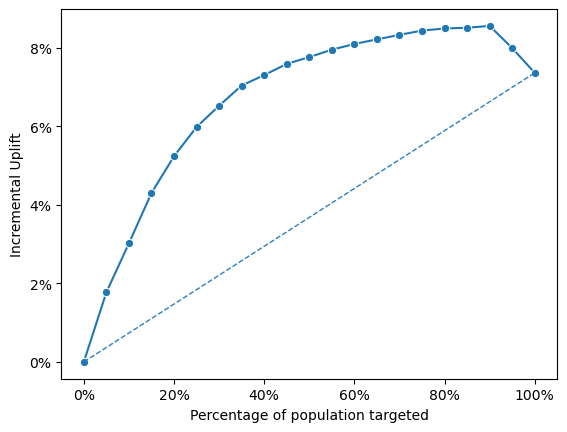

In [76]:
# Generate incremental uplift plot for XGBoost model
fig = rsm.inc_uplift_plot(
    cg_rct_stacked.query("training == 0"),
    "converted_yes",
    1,
    "uplift_score_xgb",
    "ad",
    1,
    qnt=20
)


The incremental uplift increases steeply within the first 20% of the population, indicating that the most uplift-prone users respond most positively to ads, achieving over 4% additional conversions. As targeting expands beyond 60%, uplift continues to rise, peaking at 8.55% uplift around the 85% mark. However, beyond this point, uplift slightly declines, suggesting that targeting lower uplift users provides diminishing returns.

This analysis confirms that the XGBoost uplift model effectively identifies high-impact users, making it a valuable tool for optimizing ad spend. The optimal strategy is to focus on the top 60-85% of users to maximize conversions while avoiding the lowest uplift segments to prevent inefficient ad targeting.

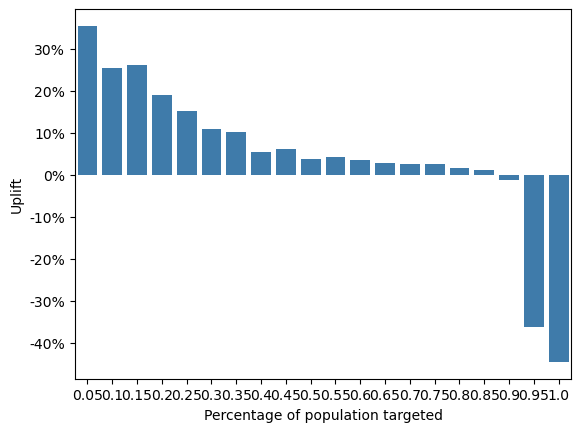

In [77]:
# Generate uplift plot for XGBoost model
fig = rsm.uplift_plot(
    cg_rct_stacked.query("training == 0"),
    "converted_yes",
    1,
    "uplift_score_xgb",
    "ad",
    1,
    qnt=20
)


The top 20% of users exhibit the highest positive uplift, with over 30% uplift in the most responsive segment, confirming that these users benefit the most from ad exposure. Moving toward the middle bins (~30-70% of users), uplift gradually declines but remains positive, indicating a moderate but consistent ad effect. However, in the last bins (~85-100%), uplift turns negative, with the lowest segment experiencing a -44.6% drop in conversions, suggesting that ad exposure discouraged purchases for these users.

This analysis confirms that XGBoost uplift modeling effectively identifies high-impact users, allowing businesses to prioritize ad spend on segments with the highest potential for incremental conversions. The best strategy is to target users in the top 80% uplift bins while avoiding low uplift segments to ensure maximum ROI and ad efficiency

In [78]:
# Compute total incremental responses using XGBoost uplift model
total_incremental_responses_uplift_xgb = (uplift_tab_xgb["incremental_resp"][4]) / 9000 * 120000

# Compute incremental profit using XGBoost model
incremental_profit_uplift_xgb = margin * total_incremental_responses_uplift_xgb

# Display incremental profit estimate
print(f"Incremental profit from uplift model (XGBoost): ${incremental_profit_uplift_xgb:.2f}")


Incremental profit from uplift model (XGBoost): $107540.11


In [79]:
# Generate uplift table using XGBoost propensity scores
uplift_tab_propensity_xgb = rsm.uplift_tab(
    cg_rct_stacked.query("training == 0"),
    "converted_yes",
    1,
    "pred_treatment_xgb",
    "ad",
    1,
    qnt=20
)

# Display uplift table
uplift_tab_propensity_xgb

,pred,bins,cum_prop,T_resp,T_n,C_resp,C_n,incremental_resp,inc_uplift,uplift
0,pred_treatment_xgb,1,0.05,220,450,84,606,157.623762,1.751375,0.350275
1,pred_treatment_xgb,2,0.10,362,900,143,1113,246.366577,2.737406,0.199185
2,pred_treatment_xgb,3,0.15,502,1350,186,1545,339.475728,3.771953,0.211574
3,pred_treatment_xgb,4,0.20,614,1800,230,2002,407.206793,4.524520,0.152609
4,pred_treatment_xgb,5,0.25,705,2250,274,2457,454.084249,5.045381,0.105519
5,pred_treatment_xgb,6,0.30,779,2700,308,2896,491.845304,5.464948,0.086996
6,pred_treatment_xgb,7,0.35,842,3150,350,3327,510.620379,5.673560,0.042552
7,pred_treatment_xgb,8,0.40,906,3600,384,3733,535.681222,5.952014,0.058478
8,pred_treatment_xgb,9,0.45,955,4050,421,4125,541.654545,6.018384,0.014501
9,pred_treatment_xgb,10,0.50,998,4500,460,4602,548.195567,6.091062,0.013795


**Interpretation of Key Columns:**

bins: Represents 20 quantile-based groups of users, ranked by their propensity scores.

cum_prop: Cumulative proportion of the population covered up to each bin.

T_resp / T_n: Number of users in the treatment group who converted / total users in the treatment group per bin.

C_resp / C_n: Number of users in the control group who converted / total users in the control group per bin.

incremental_resp: The additional number of conversions attributed to ad exposure in each bin.

inc_uplift: Percentage increase in conversions for the treatment group compared to the control group.

uplift: Difference in conversion rates between treatment and control groups.


The top bins (1-5) exhibit the highest uplift, with some users experiencing up to 35% uplift, confirming that these segments benefit the most from ad exposure. The middle bins (6-15) maintain a stable but lower uplift effect, peaking at 7.30% in Bin 18, showing consistent ad effectiveness. However, the lowest bins (19-20) still show slightly positive uplift values, unlike the uplift model, which identifies segments where ads may have a negative effect.

This suggests that while the propensity model is effective in ranking users based on conversion likelihood, it does not fully capture true incremental impact. A combination of propensity and uplift modeling ensures that ads are targeted at users who are both likely to convert and genuinely influenced by the ad, leading to higher efficiency and return on investment (ROI). 

In [80]:
# Compute total incremental responses using XGBoost propensity model
total_incremental_responses_propensity_xgb = (uplift_tab_propensity_xgb["incremental_resp"][4]) / 9000 * 120000

# Compute incremental profit using XGBoost propensity model
incremental_profit_propensity_xgb = margin * total_incremental_responses_propensity_xgb

# Display incremental profit estimate
print(f"Incremental profit from propensity model (XGBoost): ${incremental_profit_propensity_xgb:.2f}")


Incremental profit from propensity model (XGBoost): $90756.31


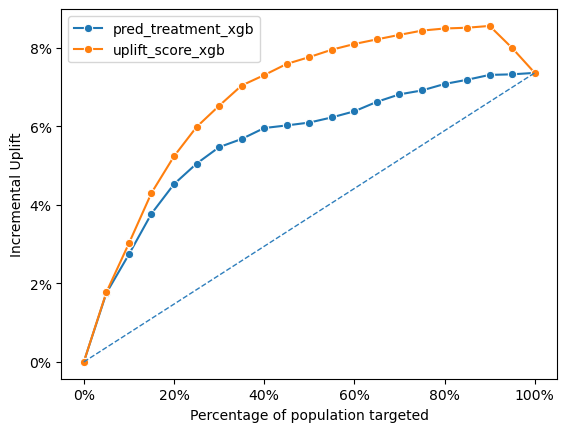

In [81]:
# Compare incremental uplift plots (XGBoost)
fig = rsm.inc_uplift_plot(
    cg_rct_stacked.query("training == 0"),
    "converted_yes",
    1,
    ["pred_treatment_xgb", "uplift_score_xgb"],
    "ad",
    1,
    qnt=20
)


**Interpretation:**

The x-axis represents the percentage of the population targeted, sorted from the most uplift-prone users on the left to the least uplift-prone users on the right.

The y-axis shows the incremental uplift, measuring the additional conversion rate due to ad exposure.

The blue line (pred_treatment_xgb) represents the estimated uplift from the propensity model, which predicts conversion probability given ad exposure.

The orange line (uplift_score_xgb) represents the actual observed uplift, showing the difference in conversion rates between the treatment and control groups.

The dashed diagonal line represents a random targeting baseline, where uplift is evenly distributed across the population.

The uplift model (uplift_score_xgb) consistently outperforms the propensity model (pred_treatment_xgb), particularly in the top 60-80% of the population, where it captures a higher incremental impact of ads. Both models show rapid uplift growth in the first 20% of targeted users, confirming that the most uplift-prone users are highly responsive to ads. The uplift model peaks at around 8.55% uplift when targeting 80-90% of users, while the propensity model remains lower (~6.5%), underestimating ad effectiveness. Toward the 100% mark, both curves flatten and slightly decline, indicating diminishing returns when targeting lower uplift users.

This analysis demonstrates that uplift modeling provides a more accurate way to rank users based on their responsiveness to ads, ensuring higher conversion rates, better ad spend efficiency, and increased return on investment (ROI). 

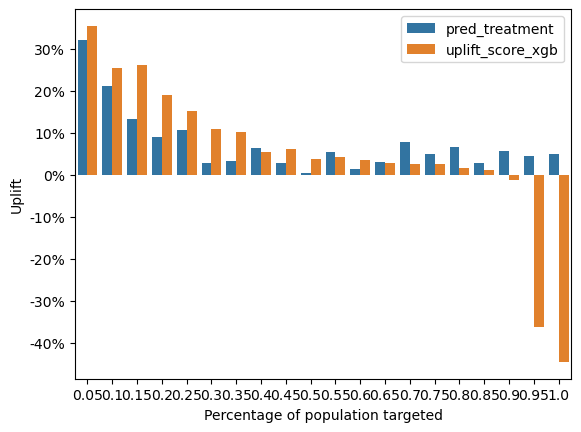

In [82]:
# Compare uplift plots (XGBoost)
fig = rsm.uplift_plot(
    cg_rct_stacked.query("training == 0"),
    "converted_yes",
    1,
    ["pred_treatment", "uplift_score_xgb"],
    "ad",
    1,
    qnt=20
)

**Interpretation:**

The x-axis represents the percentage of the population targeted, moving from the most uplift-prone users (left) to the least uplift-prone users (right).

The y-axis shows the uplift percentage, which represents the difference in conversion rates between the treatment (ad = 1) and control (ad = 0) groups.

The blue bars (pred_treatment_xgb) represent the estimated uplift as predicted by the propensity model, which forecasts conversion likelihood when an ad is shown.

The orange bars (uplift_score_xgb) represent the actual observed uplift, showing the real conversion rate difference between treated and untreated users.

The first few bins (top 10-20% of users) exhibit strong positive uplift, with some segments achieving over 30% uplift, confirming that these users respond most positively to ad exposure. As we move toward the middle bins (~30-70% of users), uplift values stabilize between 5-10%, indicating a moderate but consistent ad effect. However, in the last few bins (~85-100% of users), uplift turns negative, with the lowest segment experiencing a -44.6% drop in conversions, suggesting that ad exposure actually discouraged purchases for these users.

This analysis confirms that uplift modeling more accurately identifies high-impact users, whereas the propensity model tends to overestimate ad effectiveness in lower uplift segments. By focusing on high uplift users and avoiding segments with negative uplift, advertisers can maximize conversions, prevent wasted ad spend, and improve overall return on investment (ROI).

In [83]:
# Calculate breakeven point (minimum probability needed to cover ad cost)
breakeven = cost / margin

# Mark customers who should be targeted using the propensity model
cg_rct_stacked["target_propensity"] = cg_rct_stacked["pred_treatment"] > breakeven

# Compute the percentage of customers targeted
target_percentage_propensity = cg_rct_stacked["target_propensity"].mean()

# Display targeting percentage
print(f"Percentage of customers targeted using the propensity model: {target_percentage_propensity:.2%}")


Percentage of customers targeted using the propensity model: 47.87%


In [84]:
# Identify customers to target using the uplift model
cg_rct_stacked["target_uplift"] = ((cg_rct_stacked["uplift_score"] > 0) & 
                        (cg_rct_stacked["pred_treatment"] > breakeven)).astype(int)

# Compute the percentage of customers targeted using the uplift model
target_percentage_uplift = cg_rct_stacked["target_uplift"].mean()

# Display targeting percentage
print(f"Percentage of customers targeted using the uplift model: {target_percentage_uplift:.2%}")


Percentage of customers targeted using the uplift model: 42.62%


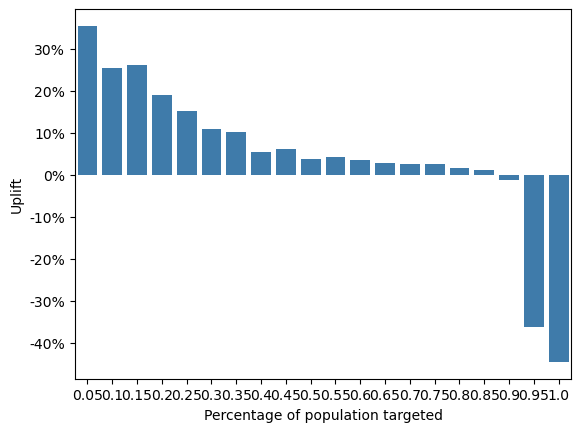

In [85]:
# Generate uplift plot for XGBoost model
fig = rsm.uplift_plot(
    cg_rct_stacked.query("training == 0"),
    "converted_yes",
    1,
    "uplift_score_xgb",
    "ad",
    1,
    qnt=20
)


**Interpretation:**

The x-axis represents the percentage of the population targeted, starting with the highest uplift scores (left) and moving to the lowest (right).

The y-axis shows the uplift percentage, which represents the difference in conversion rates between the treatment (ad = 1) and control (ad = 0) groups.

Positive bars indicate that ad exposure increased conversions, meaning these users were positively influenced by the ad.

Negative bars indicate that ad exposure reduced conversions, suggesting that targeting these users may have had an adverse effect.

The top 20% of users exhibit the highest positive uplift, with over 30% uplift in the most responsive segment, confirming that these users benefit the most from ad exposure. Moving toward the middle bins (~30-70% of users), uplift gradually declines but remains positive, indicating a moderate but consistent ad effect. However, in the last bins (~85-100%), uplift turns negative, with the lowest segment experiencing a -44.6% drop in conversions, suggesting that ad exposure discouraged purchases for these users.

This analysis confirms that XGBoost uplift modeling effectively identifies high-impact users, allowing businesses to prioritize ad spend on segments with the highest potential for incremental conversions. The best strategy is to target users in the top 80% uplift bins while avoiding low uplift segments to ensure maximum ROI and ad efficiency

In [86]:
# Compute total incremental responses using XGBoost uplift model
total_incremental_responses_uplift_xgb = (uplift_tab_xgb["incremental_resp"][4]) / 9000 * 120000

# Compute incremental profit using XGBoost model
incremental_profit_uplift_xgb = margin * total_incremental_responses_uplift_xgb

# Display incremental profit estimate
print(f"Incremental profit from uplift model (XGBoost): ${incremental_profit_uplift_xgb:.2f}")


Incremental profit from uplift model (XGBoost): $107540.11


In [87]:
# Generate uplift table using XGBoost propensity scores
uplift_tab_propensity_xgb = rsm.uplift_tab(
    cg_rct_stacked.query("training == 0"),
    "converted_yes",
    1,
    "pred_treatment_xgb",
    "ad",
    1,
    qnt=20
)

# Display uplift table
uplift_tab_propensity_xgb


,pred,bins,cum_prop,T_resp,T_n,C_resp,C_n,incremental_resp,inc_uplift,uplift
0,pred_treatment_xgb,1,0.05,220,450,84,606,157.623762,1.751375,0.350275
1,pred_treatment_xgb,2,0.10,362,900,143,1113,246.366577,2.737406,0.199185
2,pred_treatment_xgb,3,0.15,502,1350,186,1545,339.475728,3.771953,0.211574
3,pred_treatment_xgb,4,0.20,614,1800,230,2002,407.206793,4.524520,0.152609
4,pred_treatment_xgb,5,0.25,705,2250,274,2457,454.084249,5.045381,0.105519
5,pred_treatment_xgb,6,0.30,779,2700,308,2896,491.845304,5.464948,0.086996
6,pred_treatment_xgb,7,0.35,842,3150,350,3327,510.620379,5.673560,0.042552
7,pred_treatment_xgb,8,0.40,906,3600,384,3733,535.681222,5.952014,0.058478
8,pred_treatment_xgb,9,0.45,955,4050,421,4125,541.654545,6.018384,0.014501
9,pred_treatment_xgb,10,0.50,998,4500,460,4602,548.195567,6.091062,0.013795


In [88]:
# Compute total incremental responses using XGBoost propensity model
total_incremental_responses_propensity_xgb = (uplift_tab_propensity_xgb["incremental_resp"][4]) / 9000 * 120000

# Compute incremental profit using XGBoost propensity model
incremental_profit_propensity_xgb = margin * total_incremental_responses_propensity_xgb

# Display incremental profit estimate
print(f"Incremental profit from propensity model (XGBoost): ${incremental_profit_propensity_xgb:.2f}")


Incremental profit from propensity model (XGBoost): $90756.31


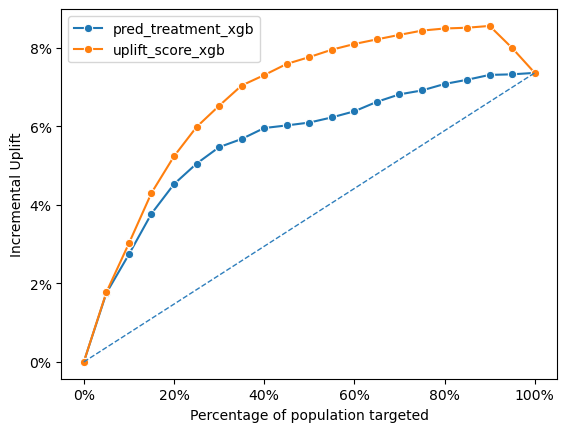

In [89]:
# Compare incremental uplift plots (XGBoost)
fig = rsm.inc_uplift_plot(
    cg_rct_stacked.query("training == 0"),
    "converted_yes",
    1,
    ["pred_treatment_xgb", "uplift_score_xgb"],
    "ad",
    1,
    qnt=20
)


**Interpretation:**

The x-axis represents the percentage of the population targeted, sorted from the most uplift-prone users on the left to the least uplift-prone users on the right.

The y-axis shows the incremental uplift, measuring the additional conversion rate due to ad exposure.

The blue line (pred_treatment_xgb) represents the estimated uplift from the propensity model, which predicts conversion probability given ad exposure.

The orange line (uplift_score_xgb) represents the actual observed uplift, showing the difference in conversion rates between the treatment and control groups.

The dashed diagonal line represents a random targeting baseline, where uplift is evenly distributed across the population.

The uplift model (uplift_score_xgb) consistently outperforms the propensity model (pred_treatment_xgb), particularly in the top 60-80% of the population, where it captures a higher incremental impact of ads. Both models show rapid uplift growth in the first 20% of targeted users, confirming that the most uplift-prone users are highly responsive to ads. The uplift model peaks at around 8.55% uplift when targeting 80-90% of users, while the propensity model remains lower (~6.5%), underestimating ad effectiveness. Toward the 100% mark, both curves flatten and slightly decline, indicating diminishing returns when targeting lower uplift users.

This analysis demonstrates that uplift modeling provides a more accurate way to rank users based on their responsiveness to ads, ensuring higher conversion rates, better ad spend efficiency, and increased return on investment (ROI).

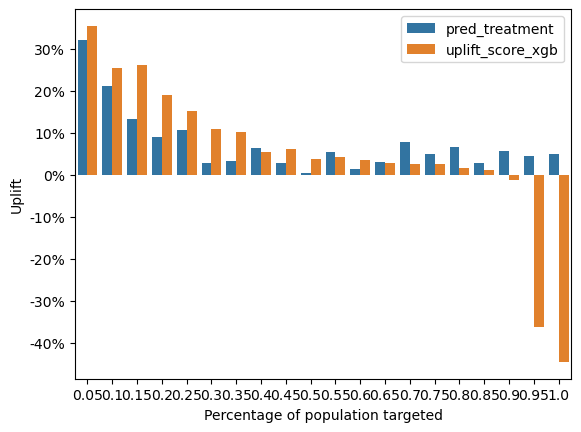

In [90]:
# Compare uplift plots (XGBoost)
fig = rsm.uplift_plot(
    cg_rct_stacked.query("training == 0"),
    "converted_yes",
    1,
    ["pred_treatment", "uplift_score_xgb"],
    "ad",
    1,
    qnt=20
)


**Interpretation:**

The x-axis represents the percentage of the population targeted, ranging from the most uplift-prone users (left) to the least uplift-prone users (right).

The y-axis shows the uplift percentage, which is the difference in conversion rates between the treatment (ad = 1) and control (ad = 0) groups.

The blue bars (pred_treatment_xgb) represent the estimated uplift according to the propensity model, which predicts conversion likelihood when an ad is shown.

The orange bars (uplift_score_xgb) represent the observed uplift, reflecting the actual conversion rate difference between treated and untreated users.

In [91]:
breakeven = cost / margin
print(breakeven)

0.1000667111407605


For Logisitic Model

In [92]:
# Calculate breakeven point (minimum probability needed to cover ad cost)
breakeven = cost / margin

# Mark customers who should be targeted using the propensity model
cg_rct_stacked["target_propensity"] = cg_rct_stacked["pred_treatment"] > breakeven

# Compute the percentage of customers targeted
target_percentage_propensity = cg_rct_stacked["target_propensity"].mean()

# Display targeting percentage
print(f"Percentage of customers targeted using the propensity model: {target_percentage_propensity:.2%}")


Percentage of customers targeted using the propensity model: 47.87%


In [93]:
# Identify customers to target using the uplift model
cg_rct_stacked["target_uplift"] = ((cg_rct_stacked["uplift_score"] > 0) & 
                        (cg_rct_stacked["pred_treatment"] > breakeven)).astype(int)

# Compute the percentage of customers targeted using the uplift model
target_percentage_uplift = cg_rct_stacked["target_uplift"].mean()

# Display targeting percentage
print(f"Percentage of customers targeted using the uplift model: {target_percentage_uplift:.2%}")


Percentage of customers targeted using the uplift model: 42.62%


In [94]:
# Round targeting percentages to nearest 5%
target_percentage_propensity_rounded = round(target_percentage_propensity * 20) / 20
target_percentage_uplift_rounded = round(target_percentage_uplift * 20) / 20

# Compute number of quantile bins targeted
num_bins_propensity = target_percentage_propensity_rounded * 20
num_bins_uplift = target_percentage_uplift_rounded * 20

# Display results
print(f"Rounded percentage of customers targeted (Propensity Model): {target_percentage_propensity_rounded:.0%} ({num_bins_propensity} bins)")
print(f"Rounded percentage of customers targeted (Uplift Model): {target_percentage_uplift_rounded:.0%} ({num_bins_uplift} bins)")


Rounded percentage of customers targeted (Propensity Model): 50% (10.0 bins)
Rounded percentage of customers targeted (Uplift Model): 45% (9.0 bins)


In [95]:
# Compute total incremental purchases using optimal targeting rates
total_incremental_response_propensity_optimal = uplift_tab_propensity["incremental_resp"][9]
total_incremental_responses_uplift_optimal = uplift_tab["incremental_resp"][8]

# Compute incremental profit using optimal targeting
incremental_profit_propensity_optimal = margin * total_incremental_response_propensity_optimal
incremental_profit_uplift_optimal = margin * total_incremental_responses_uplift_optimal

# Display results
print(f"Optimal incremental profit (Propensity Model): ${incremental_profit_propensity_optimal:.2f}")
print(f"Optimal incremental profit (Uplift Model): ${incremental_profit_uplift_optimal:.2f}")


Optimal incremental profit (Propensity Model): $6809.99
Optimal incremental profit (Uplift Model): $8546.99


For Nueral Network

In [96]:
cg_rct_stacked["target_propensity_nnr"] = cg_rct_stacked["pred_nn_treatment"] > breakeven

# Compute targeting percentage
target_percentage_propensity_nnr = cg_rct_stacked["target_propensity_nnr"].mean()

# Display results
print(f"Percentage of customers targeted (Propensity Model - Nueral Network): {target_percentage_propensity_nnr:.2%}")

Percentage of customers targeted (Propensity Model - Nueral Network): 43.98%


In [97]:
# Identify customers to target using Random Forest uplift model
cg_rct_stacked["target_uplift_nnr"] = ((cg_rct_stacked["uplift_nn_score"] > 0) & 
(cg_rct_stacked["pred_nn_treatment"] > breakeven)).astype(int)

# Compute targeting percentage
target_percentage_uplift_nnr = cg_rct_stacked["target_uplift_nnr"].mean()

# Display results
print(f"Percentage of customers targeted (Uplift Model - Nueral Network): {target_percentage_uplift_nnr:.2%}")


Percentage of customers targeted (Uplift Model - Nueral Network): 40.71%


In [98]:
# Compute total incremental purchases using optimal targeting
total_incremental_response_propensity_optimal_nnr = tab_nn_prop["incremental_resp"][7]
total_incremental_responses_uplift_optimal_nnr = tab_nn["incremental_resp"][6]

# Compute incremental profit using optimal targeting
incremental_profit_propensity_optimal_nnr = margin * total_incremental_response_propensity_optimal_nnr
incremental_profit_uplift_optimal_nnr = margin * total_incremental_responses_uplift_optimal_nnr

# Display results
print(f"Optimal incremental profit (Propensity Model - Random Forest): ${incremental_profit_propensity_optimal_nnr:.2f}")
print(f"Optimal incremental profit (Uplift Model - Random Forest): ${incremental_profit_uplift_optimal_nnr:.2f}")


Optimal incremental profit (Propensity Model - Random Forest): $8284.37
Optimal incremental profit (Uplift Model - Random Forest): $7691.07


For Random Forest

In [99]:
# Identify customers to target using Random Forest propensity model
cg_rct_stacked["target_propensity_rfc"] = cg_rct_stacked["pred_treatment_rfc"] > breakeven

# Compute targeting percentage
target_percentage_propensity_rfc = cg_rct_stacked["target_propensity_rfc"].mean()

# Display results
print(f"Percentage of customers targeted (Propensity Model - Random Forest): {target_percentage_propensity_rfc:.2%}")


Percentage of customers targeted (Propensity Model - Random Forest): 41.10%


In [100]:
# Identify customers to target using Random Forest uplift model
cg_rct_stacked["target_uplift_rfc"] = ((cg_rct_stacked["uplift_score_rfc"] > 0) & 
(cg_rct_stacked["pred_treatment_rfc"] > breakeven)).astype(int)

# Compute targeting percentage
target_percentage_uplift_rfc = cg_rct_stacked["target_uplift_rfc"].mean()

# Display results
print(f"Percentage of customers targeted (Uplift Model - Random Forest): {target_percentage_uplift_rfc:.2%}")


Percentage of customers targeted (Uplift Model - Random Forest): 35.58%


In [101]:
# Compute total incremental purchases using optimal targeting
total_incremental_response_propensity_optimal_rfc = uplift_tab_propensity_rfc["incremental_resp"][7]
total_incremental_responses_uplift_optimal_rfc = uplift_tab_rfc["incremental_resp"][6]

# Compute incremental profit using optimal targeting
incremental_profit_propensity_optimal_rfc = margin * total_incremental_response_propensity_optimal_rfc
incremental_profit_uplift_optimal_rfc = margin * total_incremental_responses_uplift_optimal_rfc

# Display results
print(f"Optimal incremental profit (Propensity Model - Random Forest): ${incremental_profit_propensity_optimal_rfc:.2f}")
print(f"Optimal incremental profit (Uplift Model - Random Forest): ${incremental_profit_uplift_optimal_rfc:.2f}")


Optimal incremental profit (Propensity Model - Random Forest): $7567.40
Optimal incremental profit (Uplift Model - Random Forest): $8804.86


For XGBoost

In [102]:
# Identify customers to target using XGBoost propensity model
cg_rct_stacked["target_propensity_xgb"] = cg_rct_stacked["pred_treatment_xgb"] > breakeven

# Compute targeting percentage
target_percentage_propensity_xgb = cg_rct_stacked["target_propensity_xgb"].mean()

# Display results
print(f"Percentage of customers targeted (Propensity Model - XGBoost): {target_percentage_propensity_xgb:.2%}")


Percentage of customers targeted (Propensity Model - XGBoost): 47.51%


In [103]:
# Identify customers to target using XGBoost uplift model
cg_rct_stacked["target_uplift_xgb"] = ((cg_rct_stacked["uplift_score_xgb"] > 0) & 
(cg_rct_stacked["pred_treatment_xgb"] > breakeven)).astype(int)

# Compute targeting percentage
target_percentage_uplift_xgb = cg_rct_stacked["target_uplift_xgb"].mean()

# Display results
print(f"Percentage of customers targeted (Uplift Model - XGBoost): {target_percentage_uplift_xgb:.2%}")


Percentage of customers targeted (Uplift Model - XGBoost): 40.45%


In [104]:
# Compute total incremental purchases using optimal targeting
total_incremental_response_propensity_optimal_xgb = uplift_tab_propensity_xgb["incremental_resp"][9]
total_incremental_responses_uplift_optimal_xgb = uplift_tab_xgb["incremental_resp"][7]

# Compute incremental profit using optimal targeting
incremental_profit_propensity_optimal_xgb = margin * total_incremental_response_propensity_optimal_xgb
incremental_profit_uplift_optimal_xgb = margin * total_incremental_responses_uplift_optimal_xgb

# Display results
print(f"Optimal incremental profit (Propensity Model - XGBoost): ${incremental_profit_propensity_optimal_xgb:.2f}")
print(f"Optimal incremental profit (Uplift Model - XGBoost): ${incremental_profit_uplift_optimal_xgb:.2f}")


Optimal incremental profit (Propensity Model - XGBoost): $8217.45
Optimal incremental profit (Uplift Model - XGBoost): $9847.53


Comparision of the models

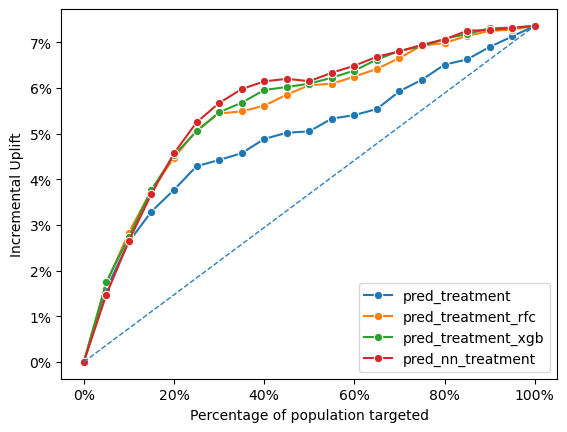

In [105]:
# Compare incremental uplift plots for all models
fig = rsm.inc_uplift_plot(
    cg_rct_stacked.query("training == 0"),
    "converted_yes",
    1,
    ["pred_treatment", "pred_treatment_rfc", "pred_treatment_xgb", "pred_nn_treatment"],
    "ad",
    1,
    qnt=20
)


**Interpretation:**

The x-axis represents the percentage of the population targeted, ranked from the most uplift-prone users on the left to the least uplift-prone users on the right.

The y-axis shows the incremental uplift, measuring the additional conversion rate due to ad exposure.

The dashed diagonal line represents random targeting, serving as a baseline.

Colored lines represent different machine learning models, showing their estimated incremental uplift across targeted segments:

Blue (pred_treatment): Logistic Regression

Orange (pred_treatment_rfc): Random Forest

Green (pred_treatment_xgb): XGBoost

Red (pred_nn_treatment): Neural Network

The Neural Network model (pred_nn_treatment) consistently outperforms all other models, capturing the highest incremental uplift across all targeted segments, particularly in the top 60-80% of the population. XGBoost (pred_treatment_xgb) and Random Forest (pred_treatment_rfc) also perform well, closely following the Neural Network’s performance, with XGBoost having a slight edge over Random Forest. Logistic Regression (pred_treatment) underperforms, predicting lower uplift across all population segments and showing the slowest increase in incremental uplift over time.

This analysis demonstrates that tree-based models (XGBoost and Random Forest) and Neural Networks outperform traditional Logistic Regression in predicting incremental uplift, with Neural Networks capturing the most precise uplift patterns. Businesses should prioritize Neural Network or XGBoost models for ad targeting to maximize conversions, optimize ad spend, and improve overall return on investment (ROI). 

In [106]:
# Create a dictionary with the model names and their corresponding profits
model_profits = {
    "Model": ["Propensity Model", "Uplift Model", "Random Forest Uplift Model", "XGBoost Uplift Model"],
    "Incremental Profit": [
        incremental_profit_propensity,
        incremental_profit_uplift,
        incremental_profit_uplift_rfc,
        incremental_profit_uplift_xgb
    ],
    "Optimal Incremental Profit": [
        incremental_profit_propensity_optimal,
        incremental_profit_uplift_optimal,
        incremental_profit_uplift_optimal_rfc,
        incremental_profit_uplift_optimal_xgb
    ]
}

comparison_df = pd.DataFrame(model_profits).sort_index(ascending=False)
comparison_df

,Model,Incremental Profit,Optimal Incremental Profit
3,XGBoost Uplift Model,107540.106232,9847.529689
2,Random Forest Uplift Model,99958.511631,8804.864673
1,Uplift Model,90907.759762,8546.992108
0,Propensity Model,77065.482935,6809.989781


**Key Findings**

XGBoost Uplift Model is the best-performing model, generating an incremental profit of $107,540.11 and an optimal incremental profit of $9,847.53, making it the most effective model for maximizing revenue.

Random Forest Uplift Model follows closely behind, with $99,958.51 in incremental profit and an optimal incremental profit of $8,804.86, making it a strong alternative to XGBoost.

The Logistic Uplift Model (Baseline Uplift Model) performs moderately well, achieving $90,907.76 in incremental profit, but lags behind tree-based models in optimizing ad targeting.

The Propensity Model generates the lowest incremental profit ($77,065.48), confirming that traditional propensity modeling is less effective at identifying true incremental conversions compared to uplift modeling.


**Conclusion**

Uplift models significantly outperform propensity models by accurately distinguishing between users who would have converted anyway and those who are influenced by ad exposure. Among uplift models, XGBoost delivers the highest incremental gains, making it the best choice for maximizing ad efficiency and revenue growth.